# <center> WALMART -  STORE SALES FORECAST </center>


<img src="img\walmart.png"></img>

In [1]:
## import all the necessary libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import chart_studio.plotly as py
import os
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
from scipy import stats
from plotly.subplots import make_subplots
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_absolute_error
from sqlalchemy import create_engine # database connection
import datetime as dt
from sklearn import metrics
import pickle as pkl
from sklearn.metrics import f1_score,precision_score,recall_score
from datetime import datetime
pd.set_option('max_rows',80000,'max_columns',200)

## 1. Business Problem




<p style='font-size:18px ' ><b> Description </b></p>
<p>
Walmart is  leading multinational Retail corporation (headquarted in the USA) operates a chain of hypermarkets.
<br>The sales prediction problem was launched by Walmart via Kaggle as a part of it's recruitment process to predict their weekly store sales using the historical sales data  of 45 stores.
</p>
<br>
<i><center><b>Why is sales forecasting important? </i>
<ul> 
    <li>sales forecasting  allows companies to estimate their cost and revenue effectively accurately based on which they are able to predict their short-term and long-term performance</li>
    <li>In short we can say  forecasts help in financial planning, Sales Planning, Inventory Control,Supply chain management,cash-flow management.
 <ul/>
<br>
<ul>
<i><center><b> How is machine learning useful in this scenario ?</b></center> </i></ul>      
<p>
There is not clear cut pattern humans have set for buying and selling,However backing up the datasets spanning years into the past it's highly possible to draw patterns in sales sand consumption.Machine learning becomes prominent here because of its ability to mine through years of data to detect patterns and repetitive behaviour, which can then be leveraged to forecast sales and demand.Conventional methods like moving averages and exponential moving averages we are assuming future sales values might the some way nearer to the recent past values,thereby cannot capture the external driving factors that determine the abrupt spike in sales values in some weeks. For example in this case study we have factors like if the given week is a holiday or not.If the week is a holiday week we capture the insight that there will be spike in sales due to this factor and if there is any promotional events conducted during the week by the retailer which again will account for an impact.Using machine learning we are not just able to capture them but also these algorithms are self  correcting.(i.e) as newer data gets addeed in future , the model accostomes itself to it and learns many new uncertainities in data.
</p>   

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Predict weekly sales for each store and department based on the past years sales behaviour.

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting</p>


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting <br>
Blogs : https://medium.com/analytics-vidhya/walmart-sales-forecasting-d6bd537e4904 <br>
Research paper : “http://cs229.stanford.edu/proj2017/final-reports/5244336.pdf” <br>
Research paper : "https://www.researchgate.net/publication/339362837_Learnings_from_Kaggle's_Forecasting_Competitions"<br> Blogs : " https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/                                                    


<h2> 1.3 Real World / Business Objectives and Constraints </h2>

1. <b>Robustness</b>
    <i>Ensuring using Cross validation</i>
2. <b>Interpretability</b>  As we forecast sales and hand it over to buinesses,it is important to answer Why's ? and How's
3. Accurate prediction matters as it might impact taking business decisions
4. <b>No latency</b> requirements
5. Models should be <b>Evolutionary</b> as consumer demands/supplies  can change over time. 

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

Data was collected from year 2010 - 2012 for 45 Walmart stores. We are tasked with predicting department wise sales for each store.
<br>
We are provided with datasets : Stores.csv,train.csv,test.csv,fetaures.csv
<br><br>
<b>Dataset Size</b><br>
<li>Trainset :421570 rows (12.2MB)</li>
<li>Testset : 115064 rows (2.47MB)</li>
<li>Stores.csv : 4KB</li>
<li>features.csv: 580 KB</li>
<br>
<b>Column Descriptions </b><br>
<ul><b>Stores</b>
	<li>Type: Type of the store namely "A","B","C"</li>
	<li>Size: Size of the store .Size refers to the number of products inside the store .Range 34000 -210,000</li>
</ul>
<ul><b>Sales</b>
	<li>Store - The store number. Range 1- 45.</li>	
	<li>Dept - One of 1–99 that shows the department</li>
	<li>Date - the week</li>
	<li>Weekly_Sales -  sales for the given department in the given store</li>
	<li>IsHoliday - whether the week is a special holiday week.</li></ul>
    
<ul><b>Features</b> 
    <li>Temperature - Average temperature in the region during that week.</li>
	<li>Fuel_Price - cost of fuel in the region during that week</li>
	<li>MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA. </li> represents what quantity was available during that week. Type is from 1 - 5.
	<li>CPI - the consumer price index during that week.</li>
	<li>Unemployment - the unemployment rate during that week.</li>



<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p>It's a regression problem where we are given time series(from 05-02-2010 to 26-10-2012) data with multiple categorical and numerical features.We are tasked to predict department wise sales of each store from 02-11-2012 to 26-07-2013 .
In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data</p>.

<h3>2.2.2 Performance metric </h3>

1.<b>Weighted mean absolute error </b>

\\( {WMAE} = \frac{1}{\sum{w_i}} \sum_{i=1}^n w_i | y_i - \hat{y}_i | \\)

where
n is the number of rows.<br>
\\( \hat{y}_i \\) is the predicted sales  <br>
\\( y_i \\) is the actual sales <br>
\\( w_i \\) are weights. w = 5 if the week is a holiday week, 1 otherwise <br>

2.<b>MAE</b> <br>
3.<b>R2-(R-squared)</b>

<center><i> Why not MSE/RMSE/MAPE ?? </i></center>

* MAE seems to be a good choice for performance metric as it is robust towards outlier points than compared to RMSE,MSE.We are going to train multiple models and  we want to check how each model explains variance of the outcome.Hence we also use R-2 (R-squared) for comparing realtive model performance.Why we dont want to go forth choosing MAPE for this study .
MAPE produces undefined outcome when actual values are 0 .((1/n * sum(0-prediction / 0) ~ undefined).We also have more than 100% MAPE which is tough to interpret. MAPE treats underforecast and overforecast differently.For underforcasts we have MAPE < 100% and over forecasts have MAPE > 100%.


<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading</h2>

In [2]:
### loading our trainset and test set 
trainset = pd.read_csv("train.csv")
testset = pd.read_csv("test.csv")
featureset = pd.read_csv("features.csv")
storeset = pd.read_csv("stores.csv")

In [3]:
## Check number of rows and columns
print("Shape of trainset: ",trainset.shape)
print("Shape of testset: ",testset.shape)

Shape of trainset:  (421570, 5)
Shape of testset:  (115064, 4)


<h2> 3.2 Identifying Variables and data types</h2>

In [4]:
### Check field names of all the columns
print("Field name in trainset ",trainset.columns)
print("\n")
print("*"*100)
print("Field name in featureset ",featureset.columns)
print("\n")
print("*"*100)
print("Field name in storeset ",storeset.columns)
print("\n")
print("*"*100)

Field name in trainset  Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')


****************************************************************************************************
Field name in featureset  Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')


****************************************************************************************************
Field name in storeset  Index(['Store', 'Type', 'Size'], dtype='object')


****************************************************************************************************


In [5]:
### Check numerical and categorical variables 
print("In the above dataset the numerical variables are :\tStore,Dept,Weekly_Sales,Markdown1:5,Temperature,Fuel_Price,CPI,Unemployment,size")
print("Categorical variables are :     IsHoliday,Type")

In the above dataset the numerical variables are :	Store,Dept,Weekly_Sales,Markdown1:5,Temperature,Fuel_Price,CPI,Unemployment,size
Categorical variables are :     IsHoliday,Type


In [6]:
## let's check the dtypes of the columns
trainset.dtypes.to_frame().rename(columns={0:"Datatype"})

Datatype
Store           int64
Dept            int64
Date           object
Weekly_Sales  float64
IsHoliday        bool

* we can see that the date field is in string format lets convert to datetime using pandas to_datetime feature.

<h2> 3.3 Treating missing values and duplicates </h2>

<center><i><B>How null values can affect our data ? </B></i> <br>
<q> Missing values are common occurrences in data. Unfortunately, most predictive modeling techniques cannot handle any missing values. Therefore, this problem must be addressed prior to modeling.</q>
Missing/null values in dataset arises problems of "Value Error" while modeling     

In [7]:
## lets check missing values in our Store set 
print('Number of unique values in Store = ',storeset.nunique())
print('*'*50)
print('Null values check in Store :')
print(storeset.apply(lambda x: sum(x.isnull()),axis=0))
## lets check missing values in our feature set 
print('*'*50)
print('Unique values in feature:',featureset.nunique())
print('*'*50)
print('Null values check in Feature :')
print(featureset.apply(lambda x: sum(x.isnull()),axis=0))
## lets check missing values in our trainset 
print('*'*50)
print('Unique values in train:',trainset.nunique())
print('*'*50)
print('Null values check in train :')
print(trainset.apply(lambda x: sum(x.isnull()),axis=0))
## lets check missing values in our testset 
print('*'*50)
print('Unique values in test:',testset.nunique())
print('*'*50)
print('Null values check in test :')
print(testset.apply(lambda x: sum(x.isnull()),axis=0))

Number of unique values in Store =  Store    45
Type      3
Size     40
dtype: int64
**************************************************
Null values check in Store :
Store    0
Type     0
Size     0
dtype: int64
**************************************************
Unique values in feature: Store             45
Date             182
Temperature     4178
Fuel_Price      1011
MarkDown1       4023
MarkDown2       2715
MarkDown3       2885
MarkDown4       3405
MarkDown5       4045
CPI             2505
Unemployment     404
IsHoliday          2
dtype: int64
**************************************************
Null values check in Feature :
Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64
**************************************************
Unique values in train: Store               45
De

<b>As we can see CPI,Unemployemnt,Markdown Contains null values we can replace them with rolling mean values with period 20

In [8]:
## Number of unique stores and number unique deptartments in trainset
ustore = sorted(trainset.Store.unique())  ## unique stores list
udept = sorted(trainset.Dept.unique()) ## unique department list
udates = sorted(trainset.Date.unique()) ## unique date list
print('Total number of unique store and department and date set is ',len(ustore)*len(udept)*len(udates))

Total number of unique store and department and date set is  521235


In [9]:
print('Our trainset has store department combination of size :',len(trainset.groupby(['Store','Dept','Date']).count()))

Our trainset has store department combination of size : 421570


<i>We see that few stores have missing departments and dates and their reported weekly sales !! We will mark their weekly sales as 0 and 'ISholiday' column as False</i>



We can  merge all the different fields from stores,features,train,test to one detailed dataset which contains all the field before performing the analysis,so that it's becomes handy in analysis.As we can observe that "Store" field is common in stores and features set we can perform a merge operation on "store" field and then merge it to the train set using three common fields (i.e) "Stores,Date,IsHoliday"

As we can see other than markdown cell no field has missing values in them..Let's calculate the % of null values in them 


In [10]:
print("% of missing value in Markdown1: ",len(featureset[featureset.MarkDown1.isnull() == True])/len(featureset) * 100,"%")
print("% of missing value in Markdown2: ",len(featureset[featureset.MarkDown2.isnull() == True])/len(featureset) * 100,"%")
print("% of missing value in Markdown3: ",len(featureset[featureset.MarkDown3.isnull() == True])/len(featureset) * 100,"%")
print("% of missing value in Markdown4: ",len(featureset[featureset.MarkDown4.isnull() == True])/len(featureset) * 100,"%")
print("% of missing value in Markdown5: ",len(featureset[featureset.MarkDown5.isnull() == True])/len(featureset) * 100,"%")

% of missing value in Markdown1:  50.76923076923077 %
% of missing value in Markdown2:  64.33455433455434 %
% of missing value in Markdown3:  55.885225885225886 %
% of missing value in Markdown4:  57.7045177045177 %
% of missing value in Markdown5:  50.54945054945055 %


*  We are going to treat missing values by two ways : 
     * If there are more than 75% of null values we will drop the column as we can't even retain 75% information from them.
     * If there are less than 75% of null values we will perform imputation such as replacing with mean value per store<br>   

### Data preparation for Analysis 
* We are going to clean our featureset,train and test set 
* Impute missing values in columns CPI,Umenployment with rolling averages and mean for markdown columns
* Generate new rows for missing store ,dept combos with weekly sales as 0 
* merge all the dataset and prepare final clean datset
 

In [11]:
def clean_feature_(feature):
    ## Lets fill the nan values in CPI and unemployment with rolling mean of window size= 20  for every store and dept.
    print('Filling Null values in CPI and Unemployment with rolling averages ........')
    print('\n')
    for store in range(1,46) :
        values = feature[feature.Store == store].set_index('Date')
        feature.loc[(feature.Store == store),['CPI']] = np.array(values.CPI.fillna(values.CPI.rolling(20,min_periods=1).mean()))
        feature.loc[(feature.Store == store),['Unemployment']] = np.array(values.Unemployment.fillna(values.Unemployment.rolling(20,min_periods=1).mean()))
    
    ## let's fill markdown nan values with mean value in each store
    print('Filling Null values in Markdown with mean values in each store ........')
    print('\n')
    grp = feature.groupby('Store')
    for i in range(1,46):
        feature.loc[(feature.Store==i)&(feature.MarkDown1.isnull()==True),['MarkDown1']]= grp.MarkDown1.mean()[i]
        feature.loc[(feature.Store==i)&(feature.MarkDown2.isnull()==True),['MarkDown2']]= grp.MarkDown2.mean()[i]
        feature.loc[(feature.Store==i)&(feature.MarkDown3.isnull()==True),['MarkDown3']]= grp.MarkDown3.mean()[i]
        feature.loc[(feature.Store==i)&(feature.MarkDown4.isnull()==True),['MarkDown4']]= grp.MarkDown4.mean()[i]
        feature.loc[(feature.Store==i)&(feature.MarkDown5.isnull()==True),['MarkDown5']]= grp.MarkDown5.mean()[i]

    print('\n Null values computed for feature set ....................')  
    ### Recheck null values in feature
    print('Null values recheck in Feature :')
    print(feature.apply(lambda x: sum(x.isnull()),axis=0))
    return feature

def generate_rows(data,s,dep,d,index,type_):
    '''Function generates new row for missing values of store,department and date combination,with weekly sales as 0 
       and IsHoliday as False'''
    if type_ == 'train':
        data.loc[index] = [s,dep,d,0,False]
    else:  
        data.loc[index] = [s,dep,d,False]
    
def trte_clean(data,type_):
    udates = data.Date.unique()
    index=len(data)
    for s in ustore:
        for dep in udept:
            for d in udates: 
                ## check if s,dep,d combo is present in test set
                ispresent = bool(len(data.loc[(data.Store == s)&(data.Dept ==dep)& (data.Date == d)])) 
                ## if not present generate new row with default values
                if not ispresent:
                    generate_rows(data,s,dep,d,index,type_)
                    index+=1
                else:pass
    data.to_csv('Clean_{}.csv'.format(type_),index=False) ## contains missing values imputed csv
        
        
def data_cleaning(train,test,feature,store) :
    start_ = datetime.now()
    print('Converting datetime type from object to Datetime[ns].......')
    print('\n')
    
    ### Chaning datatype to relevent type
    train['Date']  = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])
    feature['Date'] = pd.to_datetime(feature['Date'])
    print('Conversion done in all sets............................')
    print('\n')
    print("Type of trainset datetime after conversion:", trainset['Date'].dtype)
    print('\n')
    print("Type of testset datetime after conversion:",testset['Date'].dtype)
    print('\n')
    
    ### Missing_value imputation in feature dataset
    clean_feature =  clean_feature_(feature)
    print('Computing missing values in train and test....................')
    print('\n')
    ### Mising values in train and test
    index = len(train)
    if (not os.path.isfile('Clean_train.csv')) and (not os.path.isfile('Clean_test.csv')):
        cleaned_tr = trte_clean(train,'train')
        start = datetime.now()
        print('Computing done in train....................................',datetime.now()-start)
        print('\n')
        start = datetime.now()
        cleaned_te = trte_clean(test,'test')
        print('Computing done in test....................................',datetime.now()-start)
        print('\n')
    else:
        print('Missing Values imputed train/test is present in disk!!')
        cleaned_tr = pd.read_csv("Clean_train.csv")
        cleaned_te = pd.read_csv("Clean_test.csv")

    ### Merging the data to perform univariate analysis / multivariate analyiss
    print('Final Step !! Merging columns!!.........')
    print('\n')
    ### feature,train/test,store
    feat_store = pd.merge(clean_feature,store,how='inner',on=["Store"])
    
    feat_store['Date'] = pd.to_datetime(feat_store['Date'])
    cleaned_tr['Date'] = pd.to_datetime(cleaned_tr['Date'])
    cleaned_te['Date'] = pd.to_datetime(cleaned_te['Date'])
    
    trainset_merged = pd.merge(cleaned_tr,feat_store,how='inner',on=['Store','Date']).sort_values(by=["Store","Dept",'Date']).reset_index(drop=True)
    testset_merged = pd.merge(cleaned_te,feat_store,how='inner',on=['Store',"Date"]).sort_values(by=["Store","Dept","Date"]).reset_index(drop=True)
    
    trainset_merged['set_type'] = 'Train'
    testset_merged['set_type'] = 'Test'
    
    print('Datasets cleaned and merged................................. ')
    print('\n')
    print('Shape of trainset after merge operation is :',trainset_merged.shape)
    print('\n')
    print('Shape of testset after merge operation is :',testset_merged.shape)
    print('\n')
    print('Let\'s concat train and test data together!! ')
    print('\n')
    trte_set = pd.concat([trainset_merged,testset_merged])
    print('Sorting final set in ascending based onnStore,Dept,Date combination!! ')
    trte_set.sort_values(by=['Store','Dept','Date'],inplace=True)
    print('Done--------------------------------------------------------',datetime.now()-start_)
    return clean_feature,trainset_merged,testset_merged,trte_set

In [12]:
### preparing sets
featureset,trainset_merged,testset_merged,trte_set =  data_cleaning(trainset,testset,featureset,storeset)

Converting datetime type from object to Datetime[ns].......


Conversion done in all sets............................


Type of trainset datetime after conversion: datetime64[ns]


Type of testset datetime after conversion: datetime64[ns]


Filling Null values in CPI and Unemployment with rolling averages ........


Filling Null values in Markdown with mean values in each store ........



 Null values computed for feature set ....................
Null values recheck in Feature :
Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64
Computing missing values in train and test....................


Missing Values imputed train/test is present in disk!!
Final Step !! Merging columns!!.........


Datasets cleaned and merged................................. 


Shape of trainset after merge operation is : (521235, 18)



In [13]:
# lets drop IsHoiday_y as it is a duplicate
trainset_merged.drop(columns=['IsHoliday_y'],inplace=True)
trainset_merged=trainset_merged.rename(columns={'IsHoliday_x':'IsHoliday'})
testset_merged.drop(columns=['IsHoliday_y'],inplace=True)
testset_merged=testset_merged.rename(columns={'IsHoliday_x':'IsHoliday'})
trte_set.drop(columns=['IsHoliday_y'],inplace=True)
trte_set=trte_set.rename(columns={'IsHoliday_x':'IsHoliday'})

In [14]:
trte_set.head(3)

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   

     MarkDown1    MarkDown2    MarkDown3    MarkDown4    MarkDown5  \
0  8536.592778  3346.401918  1670.797978  3653.631444  4428.307667   
1  8536.592778  3346.401918  1670.797978  3653.631444  4428.307667   
2  8536.592778  3346.401918  1670.797978  3653.631444  4428.307667   

          CPI  Unemployment Type    Size set_type  
0  211.096358         8.106    A  151315    Train  
1  211.242170         8.106    A  151315    Train  
2  211.289143         8.106    A  151315    Train

##### We have total of 45 (store) * 81 (dept) =  3645  different time series in our dataset!! 

In [15]:
## let's check the dtypes of the columns
trte_set.dtypes.to_frame().rename(columns={0:'Type'})

Type
Store                  int64
Dept                   int64
Date          datetime64[ns]
Weekly_Sales         float64
IsHoliday               bool
Temperature          float64
Fuel_Price           float64
MarkDown1            float64
MarkDown2            float64
MarkDown3            float64
MarkDown4            float64
MarkDown5            float64
CPI                  float64
Unemployment         float64
Type                  object
Size                   int64
set_type              object

In [16]:
## check null in final merged
print(trte_set.apply(lambda x: sum(x.isnull()),axis=0))

Store                0
Dept                 0
Date                 0
Weekly_Sales    142155
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1            0
MarkDown2            0
MarkDown3            0
MarkDown4            0
MarkDown5            0
CPI                  0
Unemployment         0
Type                 0
Size                 0
set_type             0
dtype: int64


Let's find duplicate value in the data based on store,department and date column

In [17]:
duplicates = len(trte_set[trte_set.duplicated(subset=['Store',"Dept",'Date'])])
print("Does the datset contain duplicate values : ",bool(duplicates))

Does the datset contain duplicate values :  False


* let's perform some validation on dataset if each store has all the unique departments  !! and each store and department combination has 182 unique rows of dates !

In [18]:
print('Unique Counts of departments for each store!!',trte_set.groupby(['Store','Date']).count()['Dept'].unique())
print('Number of dates for each store and departments',trte_set.groupby(['Store','Dept']).count()['Date'].unique())

Unique Counts of departments for each store!! [81]
Number of dates for each store and departments [182]


* We can  see there are 81 departments for each store and with 182 unique rows of weekly sales.

### Analysis on the target column 'Weekly Sales" !!

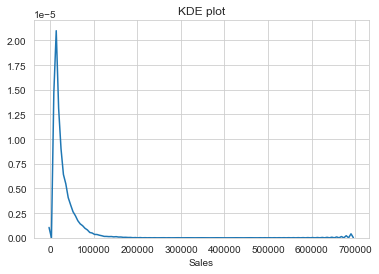

In [19]:
### Let's check the distribution of the weekly sales
x=trte_set[trte_set['Weekly_Sales']>0]['Weekly_Sales'] #x~N(0,1)
sns.set_style('whitegrid')
sns.kdeplot(np.array(x))
plt.title('KDE plot')
plt.xlabel('Sales')
plt.show()

The distribution is <b>Powerlaw</b>

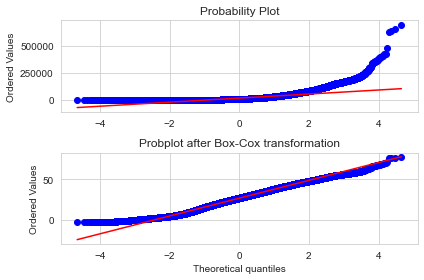

In [20]:
### performing box-cox transformation to see if we can tranform to gaussian
from scipy import stats
import matplotlib.pyplot as plt
fig=plt.figure()
ax1=fig.add_subplot(211)
## plot before box-cox
x = trte_set[trte_set['Weekly_Sales']>0]['Weekly_Sales']
prob=stats.probplot(x,dist=stats.norm,plot=ax1)
ax1.set_xlabel('')
## plot after box-cox
ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
fig.tight_layout()
plt.show()

* As we can observe clearly that the weekly_Sales data follows Power law distibution.
* After performing box-cox transformations we can observe the distribution is directed towards normal-distribution to a good extent.Howevr we are not completely able to make it gaussian.

In [21]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = trte_set["Weekly_Sales"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -4988.94
10 percentile value is 0.0
20 percentile value is 161.09
30 percentile value is 1857.1
40 percentile value is 4732.28
50 percentile value is 9287.7
60 percentile value is 17123.77
70 percentile value is 35148.19
80 percentile value is nan
90 percentile value is nan
100 percentile value is  nan


In [22]:
for i in range(0,9,1):
    var = trte_set["Weekly_Sales"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -4988.94
1 percentile value is 0.0
2 percentile value is 0.0
3 percentile value is 0.0
4 percentile value is 0.0
5 percentile value is 0.0
6 percentile value is 0.0
7 percentile value is 0.0
8 percentile value is 0.0
100 percentile value is  nan


* We see negetive weekly sales reported values in the dataset!! Weekly Sales cannot be negetive!

In [23]:
print('Number of rows which has negetive sales reported == ',len(trte_set.loc[trte_set['Weekly_Sales']<0]))

Number of rows which has negetive sales reported ==  1285


* Tranform negtively reported sales to 0 .

In [19]:
trte_set.loc[trte_set['Weekly_Sales']<0,'Weekly_Sales'] = 0 

In [25]:
print('Number of negetive sales now in set!!',len(trte_set.loc[trte_set['Weekly_Sales']<0]))

Number of negetive sales now in set!! 0


* Let's check time series (Store and Dept combos ) which has zero recorded sales for all the dates , if yes then delete those series

In [20]:
### Check time series with all 0 weekly sales values!!
grp = trte_set.groupby(['Store','Dept'])['Weekly_Sales'].sum()
print('Number of time series with all zero sales == ',len(grp[grp==0]))
store_dept_with_all_zeros_sales = list(grp[grp==0].index)

Number of time series with all zero sales ==  322


In [21]:
## reset the index 
trte_set = trte_set.reset_index(drop=True)
for i,j in  store_dept_with_all_zeros_sales:
     trte_set.drop(trte_set[(trte_set.Store == i) & (trte_set.Dept == j)].index ,inplace=True)

In [22]:
print('Total number of rows  deleted == ',182 * len(store_dept_with_all_zeros_sales))
print('Length of train and test after deletion ==',len(trte_set))

Total number of rows  deleted ==  58604
Length of train and test after deletion == 604786


<h2> 3.4 Univarite analysis </h2>

<h3>Weekly Sales x Date </h3>

In [48]:
## let's craete two date features here week,year for analysis
trte_set['week'] = trte_set['Date'].dt.week
trte_set['year'] = trte_set['Date'].dt.year
sales_per_week_year =  trte_set.groupby(['Date','week','year'],as_index=False)['Weekly_Sales'].mean()

## Plotting mean sales over years(2010-2012)
## we are plotting using plotly library to get more readability   
fig = px.line(sales_per_week_year, y="Weekly_Sales",x='week',
              title='Mean Sales - per week over the years',color='year',line_group='year',)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(1,53) ,
        ticktext = np.arange(1,53)
    )
)
fig.show()


* We can observe that during thanksgiving week(Nov 26) and christmas week(December 24) soaring peaks of sales.
* Apart from that we can observe peaks during easter week i.e April 2,2010 , April 22 ,2011 and April 6,2012 .However,these are not included as holiday weeks in our datasets.So we will include them as holiday week.
* Holidays like superbowl occurs in first sunday of feb month,labour day on first monday of september !! It will be useful to include features like week number, day, month's week number 
* Over the years 2010-2012 the time-series data followed a similar pattern.

<h3>Type X Sales</h3>

In [49]:
## Let's plot  sales per store
## USing Plotly we are creating pie chart !! Let's plot the mean sales for every week
sales_per_type =  trte_set.groupby(['Type'],as_index=False)['Weekly_Sales'].median()
fig = make_subplots(rows=1, cols=1,subplot_titles=['Type(Median)','Store(Median)'],
                   specs=[[{"type": "pie"}]])
fig.add_trace(go.Pie(labels=sales_per_type['Type'], values=sales_per_type['Weekly_Sales'],text=sales_per_type['Type']),row=1,col=1)
fig.show()

As observed from the pie-cart
* From the plot we can see that type "A" > Type "B" > Type"C" in producing sales.

<h3>Weekly Sales x Store   </h3>

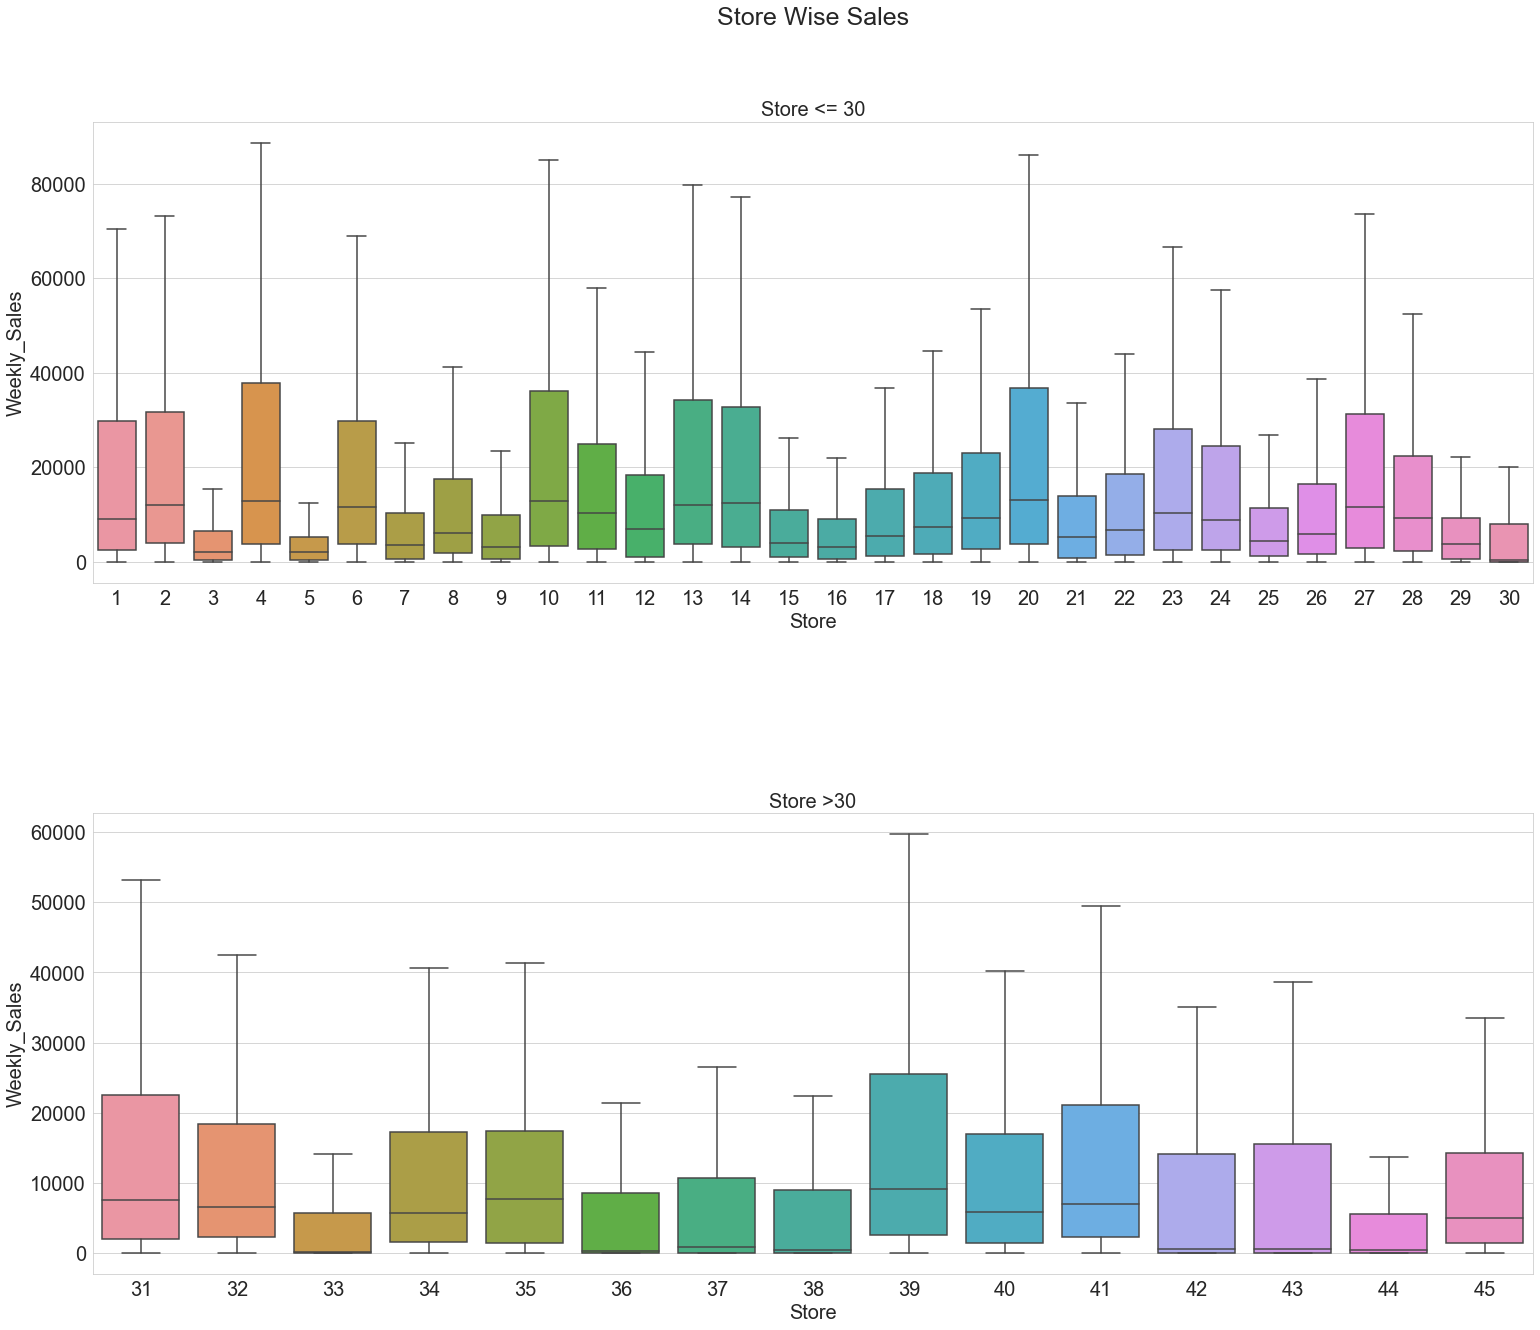

In [50]:
a=trte_set.query('Store <= 30' )
b=trte_set.query('Store >30 and Store <=60')
fig,axes = plt.subplots(2,1,figsize=(25,20)) 
fig.suptitle('Store Wise Sales',fontsize=25)

fig.subplots_adjust(wspace=0.5,hspace=0.5)
fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
### subplot for Store<30
sns.boxplot(x=a['Store'],y=a['Weekly_Sales'],showfliers=False,ax=axes[0])
axes[0].set_title('Store <= 30',fontsize=20)
axes[0].set_xlabel('Store',fontsize=20)
axes[0].set_ylabel('Weekly_Sales',fontsize=20)
axes[0].tick_params(labelsize=20)

### Store >30 
sns.boxplot(x=b['Store'],y=b['Weekly_Sales'],showfliers=False,ax=axes[1])
axes[1].set_title('Store >30',fontsize=20)
axes[1].set_xlabel('Store',fontsize=20)
axes[1].set_ylabel('Weekly_Sales',fontsize=20)
axes[1].tick_params(labelsize=20)




* Observations :
    * Few stores show higher mean sales and higher interquartile  range depicting that few stores are bigger than the others .
    * Some stores have their 25th and 50th percentile values very close and 75th percentile is far away showing that there is not much sales values difference between point below 25% and point below 50% .There was sudden increase in sales after 50 % of points.(might be flier points showing sudden increase in sales due to some external factor)
    * Theory : We can understand that the stores with the higher weekly sales(1,2,4,10...) can be categorized as type 'A' stores with medium sales as  type 'B'(11,2,19,20...) and the   rest as type 'C'(3,5,29,30...)

<h3>Weekly Sales x Dept   </h3>

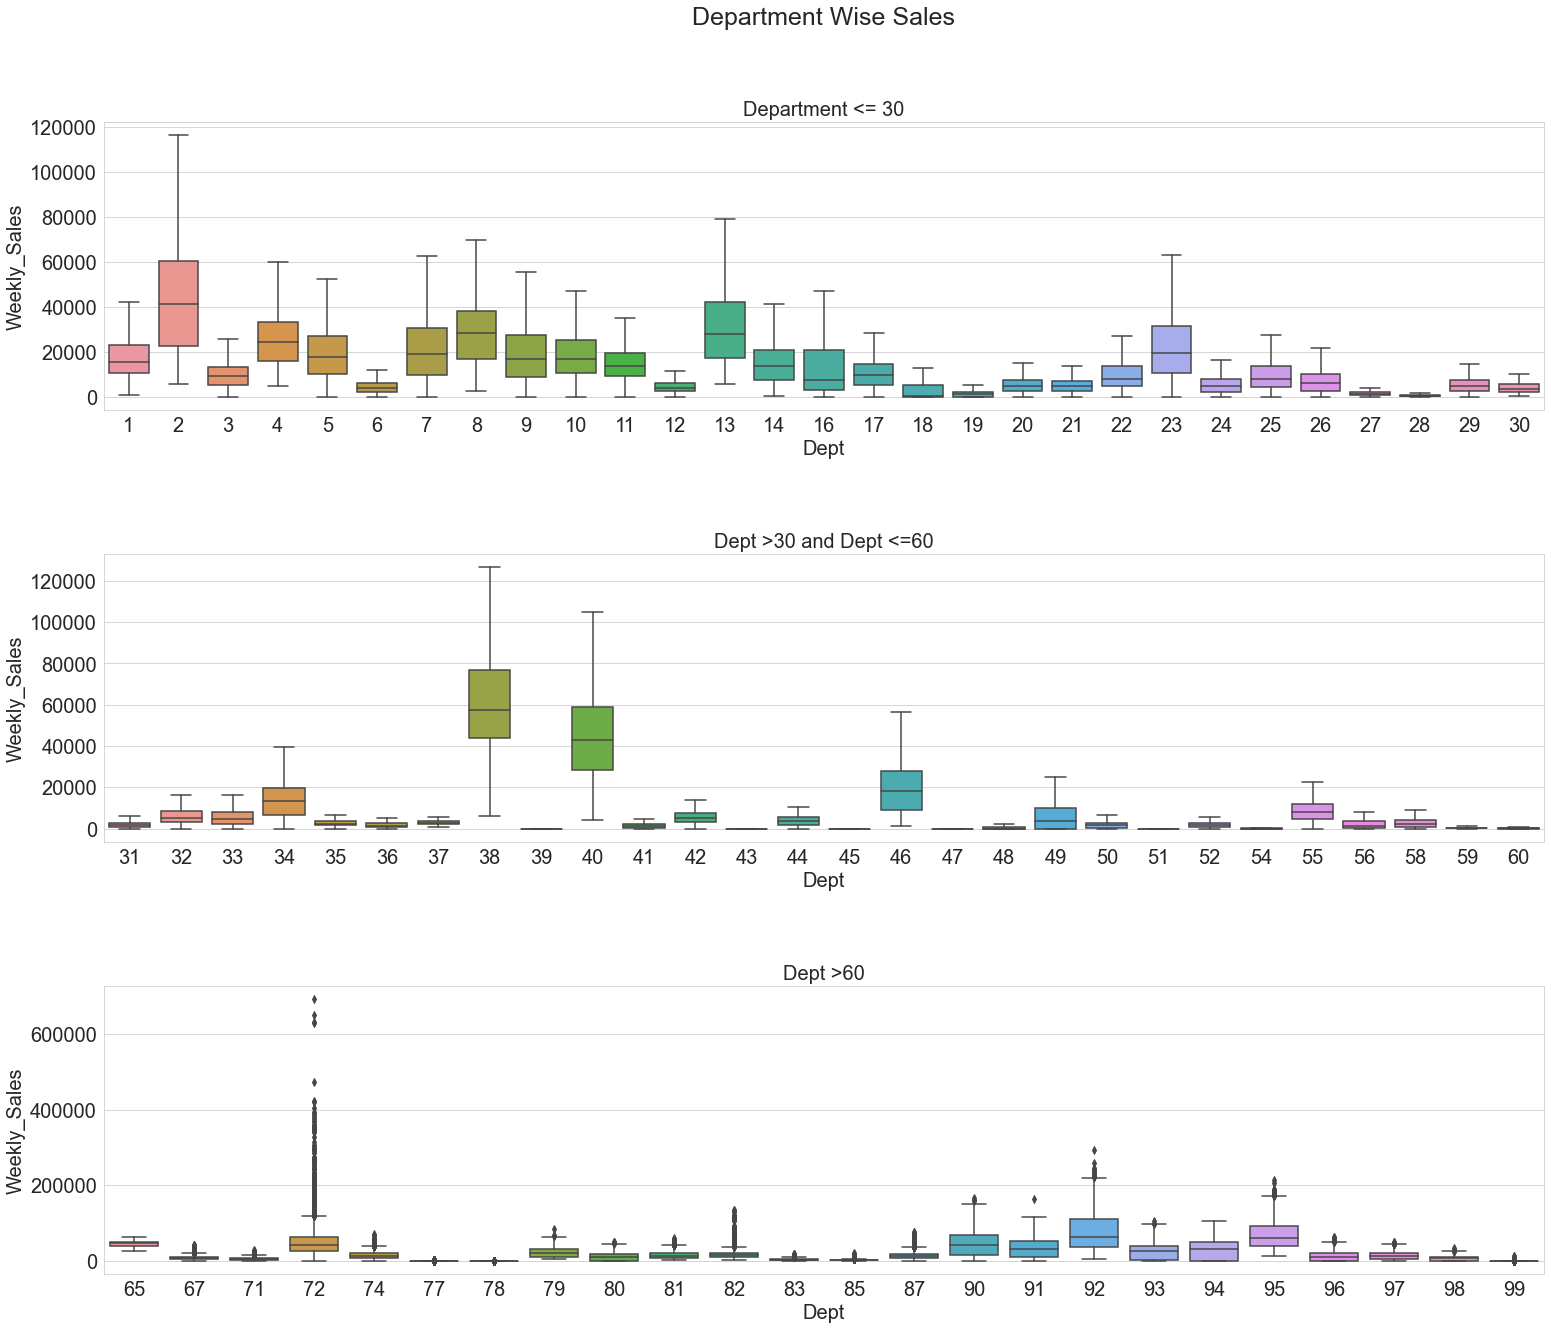

In [51]:
a=trte_set.query(' Dept <= 30' )
b=trte_set.query('Dept >30 and Dept <=60')
c=trte_set.query('Dept >60 ')
fig,axes = plt.subplots(3,1,figsize=(25,20)) 
fig.suptitle('Department Wise Sales',fontsize=25)

fig.subplots_adjust(wspace=0.5,hspace=0.5)
fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
### subplot for dept<30
sns.boxplot(x=a['Dept'],y=a['Weekly_Sales'],showfliers=False,ax=axes[0])
axes[0].set_title('Department <= 30',fontsize=20)
axes[0].set_xlabel('Dept',fontsize=20)
axes[0].set_ylabel('Weekly_Sales',fontsize=20)
axes[0].tick_params(labelsize=20)

### Dept >30 and Dept <=60
sns.boxplot(x=b['Dept'],y=b['Weekly_Sales'],showfliers=False,ax=axes[1])
axes[1].set_title('Dept >30 and Dept <=60',fontsize=20)
axes[1].set_xlabel('Dept',fontsize=20)
axes[1].set_ylabel('Weekly_Sales',fontsize=20)
axes[1].tick_params(labelsize=20)

# Dept >60
sns.boxplot(x=c['Dept'],y=c['Weekly_Sales'],ax=axes[2])
axes[2].set_title('Dept >60',fontsize=20)
axes[2].set_xlabel('Dept',fontsize=20)
axes[2].set_ylabel('Weekly_Sales',fontsize=20)
axes[2].tick_params(labelsize=20)



* We have calculated the mean sales per department and plotted it separately for readability.
* From this bar plot we can see department 2,38,40 has greater mean sales comparated to other departments which shows that 
these department have more useful products for the customer.People are more likely to buy products from these departments.
* Department 72,7,5 we can observe high sales during few weeks which is farther away from their mean sales.There is a posibility that these departments supply customers with products which are needed during Holiday Weeks.

<h3>Weekly Sales on Holidays </h3>

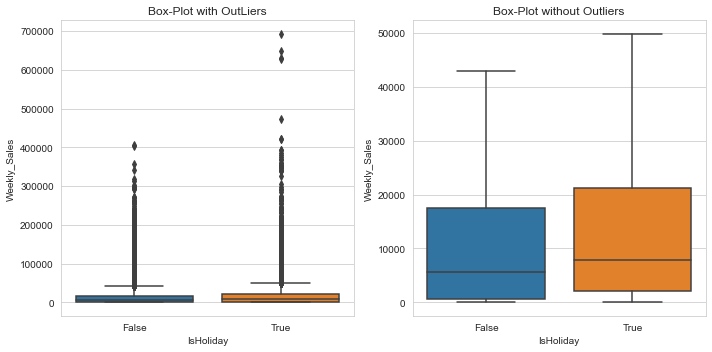

In [52]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(data=trte_set,x='IsHoliday',y='Weekly_Sales',)
plt.title("Box-Plot with OutLiers")
plt.subplot(1,2,2)
sns.boxplot(data=trte_set,x='IsHoliday',y='Weekly_Sales',showfliers=False)
plt.title('Box-Plot without Outliers')
plt.tight_layout()

<b>Observation 1</b> : As we can see outlier points on Holidays are greater than non-Holidays.The mean sales/inter-quartile range values  for both Holiday and nonholiday weeks are overlapping,Which doesn't make 'IsHoliday' a good predictor.Which indicates are only a few Holiday weeks which clearly increases sales values than non-Holiday WEeks.

### 3.5 Skewness Measure and Outlier Detection

* Linear Regression Models makes assumeptions such as the data is normally distributed,without noise,has no-collinearity which is why Skewness in data reduces the predictive power of our models,
* Let's Analyse some skewness in data.

In [53]:
### for the numerical variable CPI,employment,fuel_price lets plot kde and scatter plot
def kde_scatter(data,x,y,title):
    '''Funcation plots KDE plot and Scatter plot as subplots '''
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title,fontsize=15)
    sns.scatterplot(x=data[x],y=data[y],ax=axes[0])
    sns.distplot(data[x], kde=True,ax=axes[1])
    plt.show()

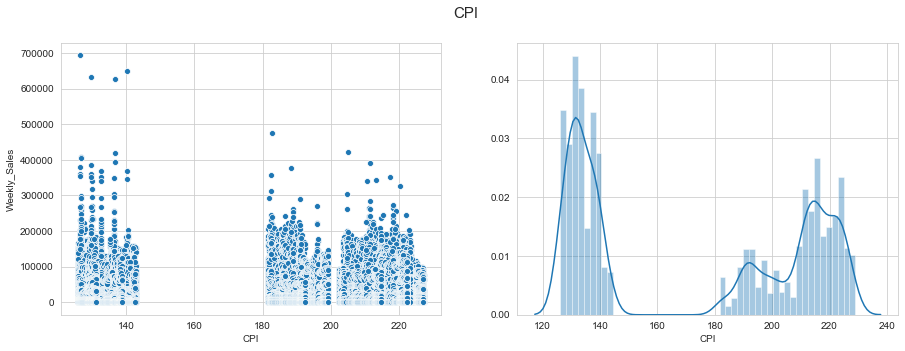

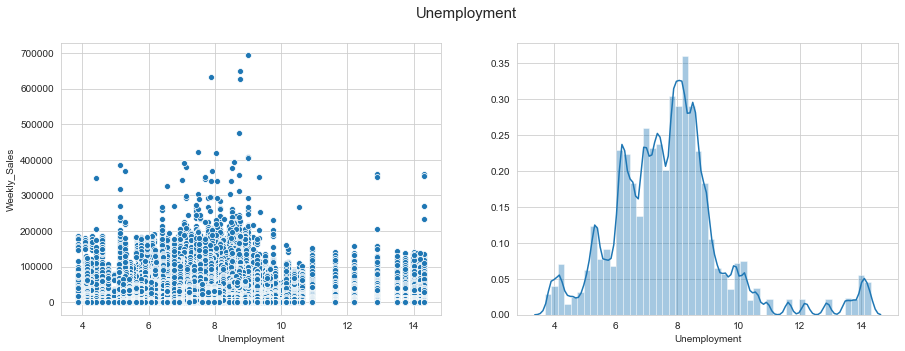

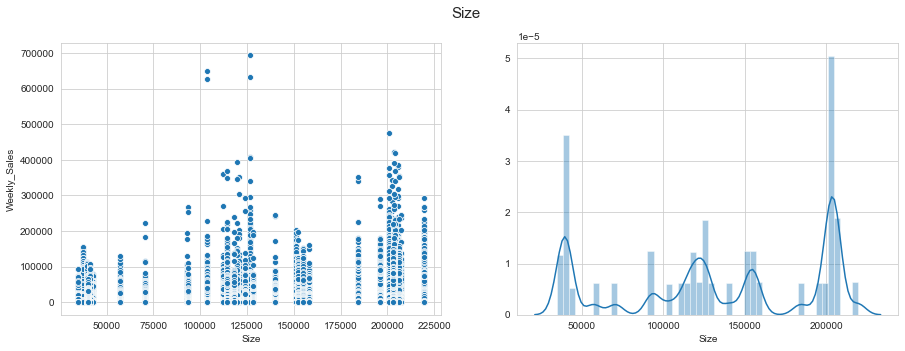

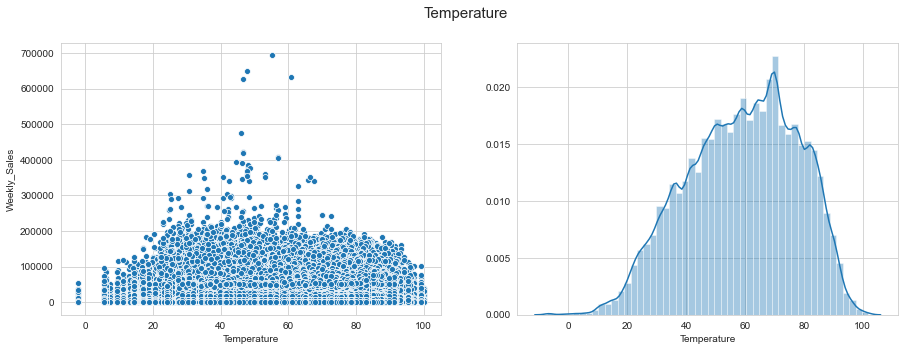

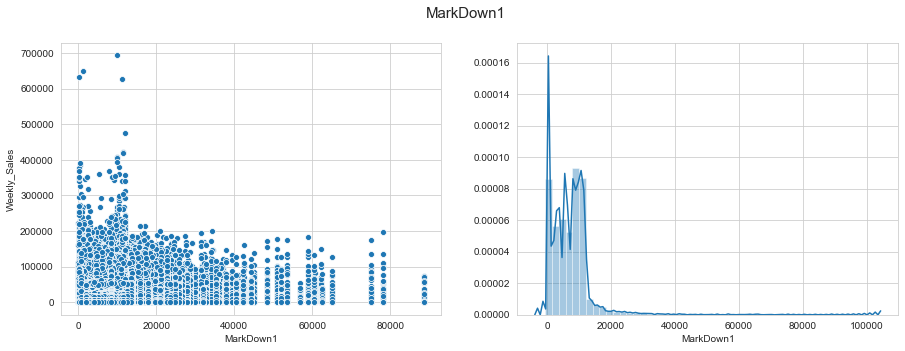

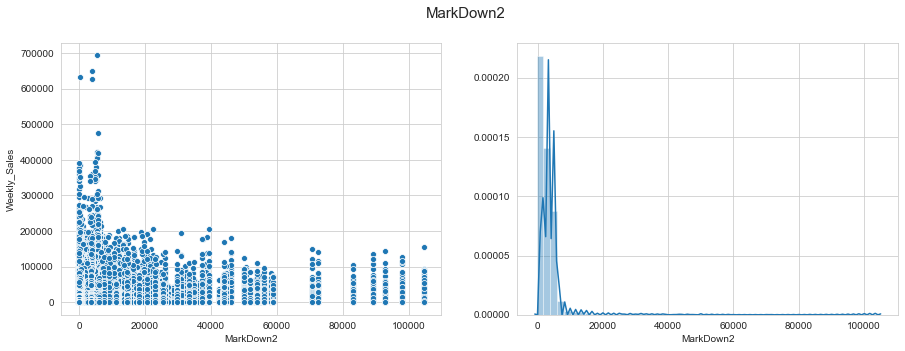

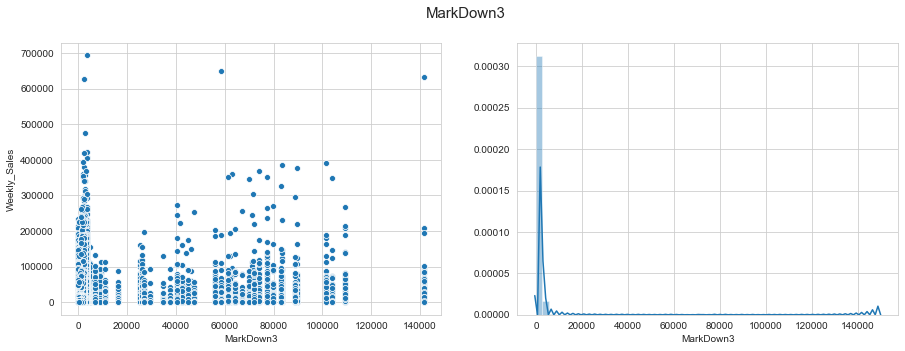

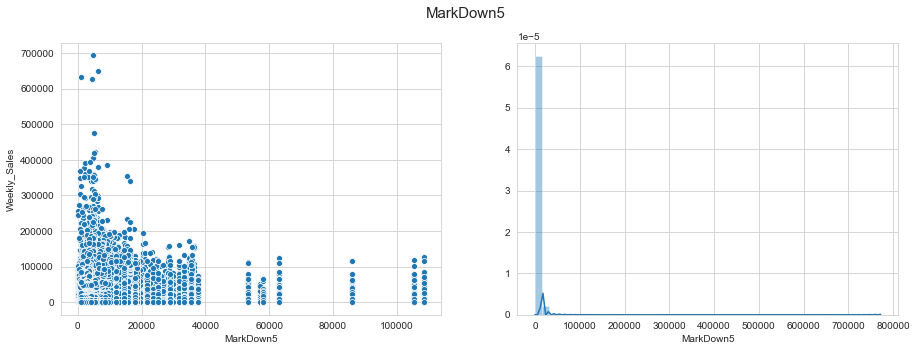

In [54]:
## plotting KDE and scatter for Numerical Variables
kde_scatter(trte_set,'CPI','Weekly_Sales',"CPI")
kde_scatter(trte_set,'Unemployment','Weekly_Sales',"Unemployment")
kde_scatter(trte_set,'Size','Weekly_Sales','Size')
kde_scatter(trte_set,'Temperature','Weekly_Sales','Temperature')
kde_scatter(trte_set,'MarkDown1','Weekly_Sales','MarkDown1')
kde_scatter(trte_set,'MarkDown2','Weekly_Sales','MarkDown2')
kde_scatter(trte_set,'MarkDown3','Weekly_Sales','MarkDown3')
kde_scatter(trte_set,'MarkDown5','Weekly_Sales','MarkDown5')

<b>Observation:</b>
We can see all the numerical features are Right-skewed
<br>
<b>Theory:</b>
We don't have to take in account of normalizing features as we are not implementing any linear models (assumes disribution to be  gaussian).
<br><br>
<i>Let's try to reduce skewness !! P.S This is just for observation purpose. We need not apply any normalizing techniques.</i>

In [55]:
from scipy.stats import skew
numerical_vars = ['CPI','Unemployment','Temperature','Size','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
## printing skewness for each variable 
for var in numerical_vars:
    print("Column name:" ,var,'\t',"Skew:",skew(trte_set[var]),' ',' neg-values',
          bool(len(trte_set.query('{} < 0'.format(var)))))
    

Column name: CPI 	 Skew: 0.08296710665638728    neg-values False
Column name: Unemployment 	 Skew: 1.0150771848243956    neg-values False
Column name: Temperature 	 Skew: -0.2741277765467456    neg-values True
Column name: Size 	 Skew: -0.2713788675521774    neg-values False
Column name: MarkDown1 	 Skew: 4.4791479745936424    neg-values True
Column name: MarkDown2 	 Skew: 7.46910934822387    neg-values True
Column name: MarkDown3 	 Skew: 11.883689905525937    neg-values True
Column name: MarkDown4 	 Skew: 6.499750652818528    neg-values False
Column name: MarkDown5 	 Skew: 65.3566601396212    neg-values True


* Since MarkDown 2,3 and Temperature contain negetive values we cannot perform log tranform
* let's consider the columns without negetive vals. 

In [56]:
def skew_corr_plot(num_var):
    '''Function to visualize reduction of skewness after performing log-transform'''
    for var in num_var:
        fig = plt.figure(figsize=(15,5))
        c = np.log(trte_set[var]) ## perform log-transform
        trte_set['norm_{}'.format(var)] = c ## create a new norm feature
        plt.subplot(141)
        sns.distplot(trte_set[var],kde=True) ### plot kde
        ## title to represent skewness of var and correlation of var
        plt.title('Skew: {} Corr: {}'.format(round(skew(trte_set.query('{}>0'.format(var))[var]),4),
                                             round(trte_set.corr()['Weekly_Sales'][var],4)),fontdict={'fontsize':20})
        plt.subplot(142)
        sns.distplot(trte_set['norm_{}'.format(var)],kde=True)
        ## title to represent skewness of var and correlation of var
        plt.title('Skew: {} Corr: {}'.format(round(skew(trte_set.query('norm_{}>0'.format(var))['norm_{}'.format(var)]),4),
                                             round(trte_set.corr()['Weekly_Sales']['norm_{}'.format(var)],4)),fontdict={'fontsize':20})
        ax=plt.subplot(143)
        stats.probplot(trte_set[var], dist=stats.norm,plot=ax) ## probability plot before transform
        ax=plt.subplot(144)
        stats.probplot(trte_set['norm_{}'.format(var)], dist=stats.norm,plot=ax ) ## probability plot after transform
        plt.tight_layout()
        plt.show()                

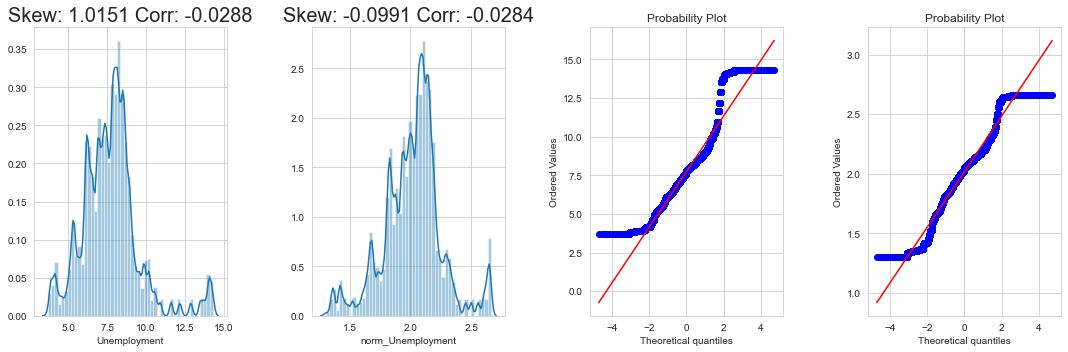

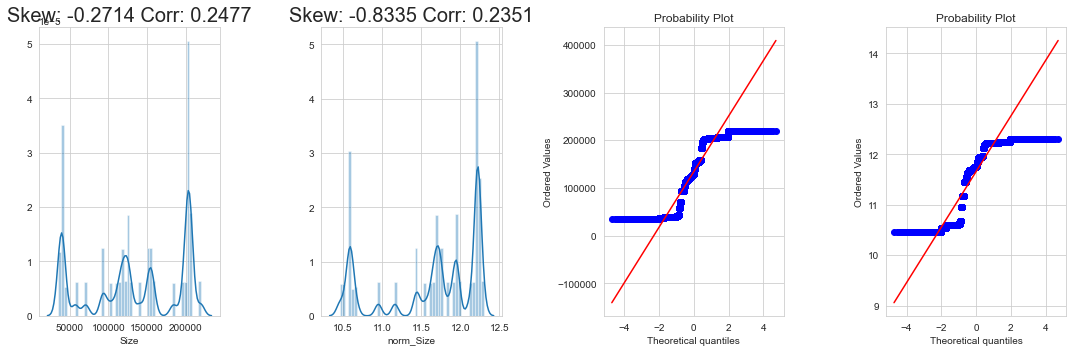

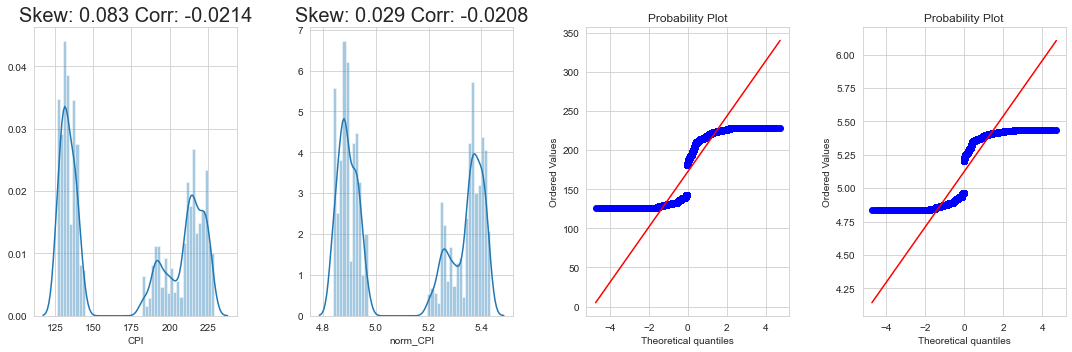

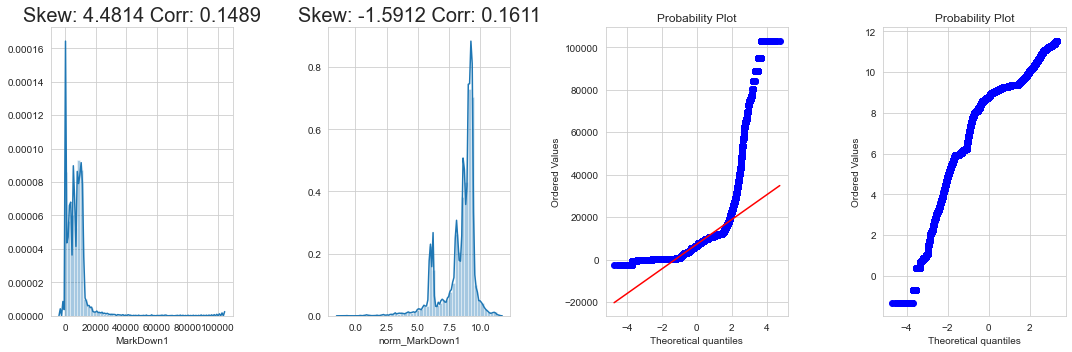

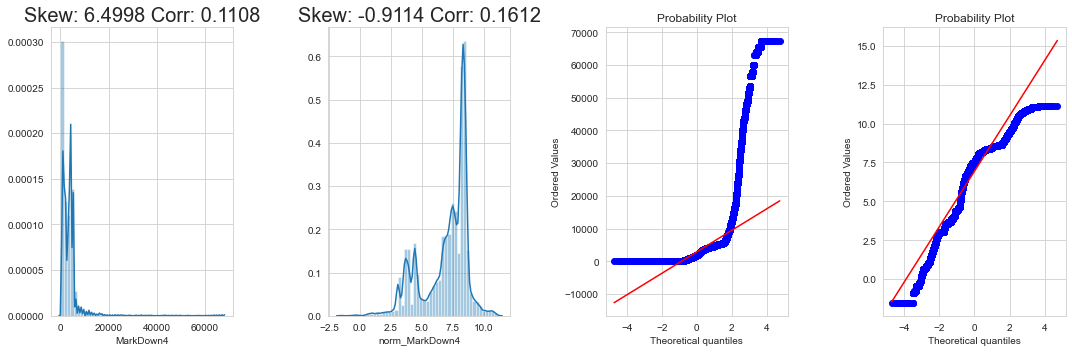

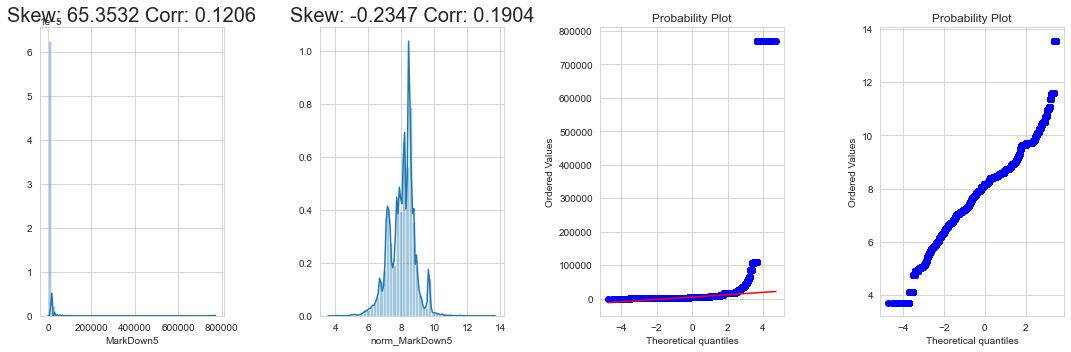

In [57]:
skew_corr_plot(['Unemployment','Size','CPI','MarkDown1','MarkDown4','MarkDown5'])

<b>Observations</b> : 
* The above graph depicts data distributions before and after performing log-transformation.
* We can see that performing log operations on the numerical distributions reduces skewness.However it doesn't completely become gaussian distributed corelations still remains the low with respect to the target variables.
* Since these markdown variables had lot of nan values and we imputed with mean values .Hence we see a very high spike at mean value. 

In [58]:
## As we dont need normalization  we will drop them
trte_set=trte_set[trte_set.columns.drop(list(trte_set.filter(regex='norm_')))]

### 3.6 Detecting outlier points in numerical Features

In [59]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = trte_set["CPI"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 126.064
10 percentile value is 129.1507742
20 percentile value is 131.686
30 percentile value is 134.17777420000002
40 percentile value is 138.3771935
50 percentile value is 182.60429219999997
60 percentile value is 197.780931
70 percentile value is 211.1886931
80 percentile value is 215.6488731
90 percentile value is 222.2174395
100 percentile value is  228.9764563


In [60]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = trte_set["Unemployment"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 3.6839999999999997
10 percentile value is 5.539
20 percentile value is 6.29
30 percentile value is 6.875999999999979
40 percentile value is 7.287000000000001
50 percentile value is 7.742000000000001
60 percentile value is 8.058
70 percentile value is 8.36
80 percentile value is 8.743
90 percentile value is 9.652999999999999
100 percentile value is  14.312999999999999


In [61]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = trte_set["Temperature"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -7.29
10 percentile value is 33.0
20 percentile value is 41.72
30 percentile value is 48.71
40 percentile value is 54.62
50 percentile value is 60.32
60 percentile value is 65.79
70 percentile value is 70.71
80 percentile value is 76.58
90 percentile value is 83.04
100 percentile value is  101.95


In [62]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = trte_set["Size"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 34875
10 percentile value is 39910
20 percentile value is 57197
30 percentile value is 103681
40 percentile value is 120653
50 percentile value is 128107
60 percentile value is 155078
70 percentile value is 200898
80 percentile value is 203742
90 percentile value is 204184
100 percentile value is  219622


* We dont observe any outlier points in the dataset.

## 4. Feature Engineering

### 4.1 Adding Basic Date,Holiday Features

* Let's create some useful date features like month,dayofweek , MajorHolidays
* We observed that in our trainset we are given with IsHoliday as true for week 52(supposedly our christmas week) but there is no spike in sales , week 51 has spike in sales which is our week before chirstmas .
* lets' create a categorical feature Major_Holidays which calculates the holiday week of Christmas,Thanksgiving and Labour day for every year.This will allow us to spot the sales spike effectively
* we will categorize them as '0' for 'Non-Major Holiday', '1' for Thanksgiving and '2' for Labour and '3' for Christmas and 4 for superbowl

In [24]:
#Ref::: ## Create a list which stores  holiday weeknumbers  as it values 
## all the holidays occurs in same week from 2010-2013
def return_holweek(data):
    d = [] 
    ## thanks giving (occurs in the last thursday of november)
    thurs_weeknum_ = data.query('month == 11')[['week','day']] ## extracting weel an day of month 11
    thanks_week_num = thurs_weeknum_.groupby('week',as_index=False).count()['week'][3] ## extracting the last week from month 11

    ## labour (occurs in the first monday of september)
    mon_weeknum = data.query('month == 9')
    if  mon_weeknum['Date'].dt.day.iloc[0] < 4:
        labour_week_num = mon_weeknum.week.iloc[1] ## if the monday occurs in 2nd week of month
    else :    
        labour_week_num = mon_weeknum.week.iloc[0]   ## if the monday occurs in 1nd week of month
    
    ## christmas (extract week number just before december 25)
    christmas_week_num = data[(data['month'] == 12 )& (data['Date'].dt.day <25) ]['week'].iloc[-1]

    ### superbowl occurs in the 6th week from 2010-2013
    d = [thanks_week_num,labour_week_num,christmas_week_num,6]
    return d

In [25]:
def basic_features(data):
    '''Returns new dataframe with basic features : month,dayofyear,quater,major sales'''

    # Creating month field 
    data['month'] = data['Date'].dt.month

    # craeting day field
    data['day'] = data['Date'].dt.day

    # creating day of the year 
    data['day_ofyear'] = data['Date'].dt.dayofyear
    
    ## creating quatrer 
    data['quater'] = data['Date'].dt.quarter   

    return data

In [26]:
trte_basic_feat = basic_features(trte_set.copy())

In [27]:
# Creating labeled feature Major Holidays
# References : 0:Not Holiday ,1:Thanksgiving ,2:Labour day, 3:Christmas, 4: Superbowl   
d = return_holweek(trte_basic_feat)
trte_basic_feat['major_holiday'] = trte_basic_feat['week'].map({d[0]:1,d[1]:2,d[2]:3,d[3]:4})
trte_basic_feat['major_holiday'].fillna(0,inplace=True)

In [28]:
trte_basic_feat.head(2)

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   

     MarkDown1    MarkDown2    MarkDown3    MarkDown4    MarkDown5  \
0  8536.592778  3346.401918  1670.797978  3653.631444  4428.307667   
1  8536.592778  3346.401918  1670.797978  3653.631444  4428.307667   

          CPI  Unemployment Type    Size set_type  week  year  month  day  \
0  211.096358         8.106    A  151315    Train     5  2010      2    5   
1  211.242170         8.106    A  151315    Train     6  2010      2   12   

   day_ofyear  quater  major_holiday  
0          36       1            0.0  
1          43       1            4.0

### 5. Multi-Variate Analysis 

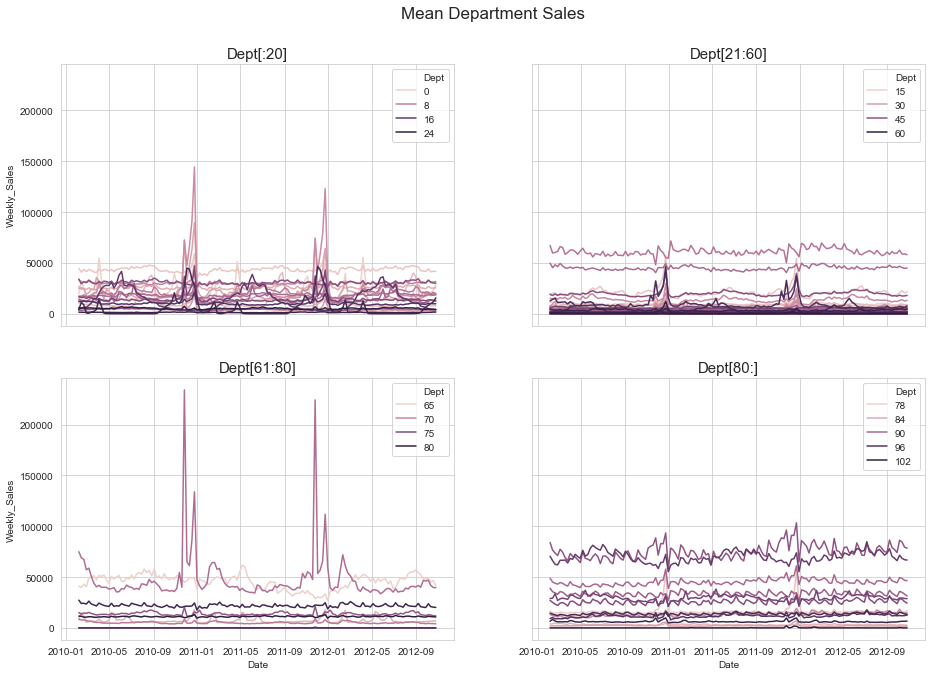

In [68]:
## Date * Department - MEans sales lineplot
dept_mean = trte_basic_feat.groupby(['Dept','Date'],as_index=False).mean()
fig, axes = plt.subplots(2, 2, figsize=(15, 10),sharey=True,sharex=True)
fig.suptitle('Mean Department Sales',fontsize=17)
fig.subplots_adjust(wspace=0.2,hspace=0.2)
fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)

sns.lineplot(ax=axes[0,0],data=dept_mean.query('Dept <= 20'),x='Date',y='Weekly_Sales',hue='Dept')
sns.lineplot(ax=axes[0,1],data=dept_mean.query('Dept > 20 and Dept <=60 '),x='Date',y='Weekly_Sales',hue='Dept')
sns.lineplot(ax=axes[1,0],data=dept_mean.query('Dept > 60 and Dept <=80'),x='Date',y='Weekly_Sales',hue='Dept')
sns.lineplot(ax=axes[1,1],data=dept_mean.query('Dept > 80'),x='Date',y='Weekly_Sales',hue='Dept')

axes[0,0].set_title('Dept[:20]',fontsize=15)
axes[0,1].set_title('Dept[21:60]',fontsize=15)
axes[1,0].set_title('Dept[61:80]',fontsize=15)
axes[1,1].set_title('Dept[80:]',fontsize=15)
plt.show()

<b>Observations</b> : 
* From the above plot we can see department seems to be a good predictor for sales.
* From plot 3 it can be observed that few departments contribute to very high mean weekly sales
* <b>Theory 1</b> : These departments might contribute majorly for sales during holidays /Major Holidaays

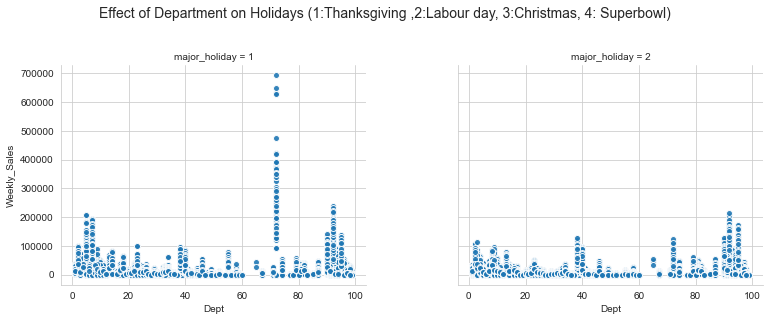

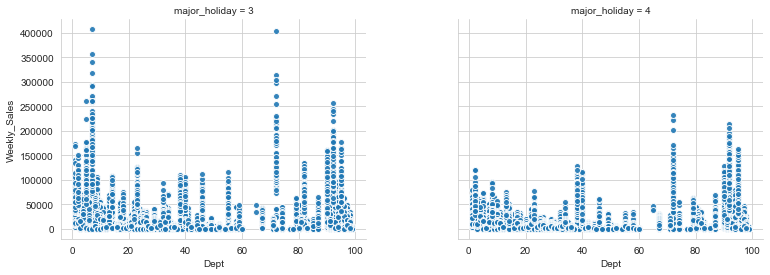

In [69]:
# Let's plot Effect of department on holidays 
g = sns.FacetGrid(trte_basic_feat, col="major_holiday",  
                  col_order=[1,2],
                  aspect=1.2, size=4.5, palette=['Yellow','Blue',"Green",'Pink'])
g.map(plt.scatter, "Dept", "Weekly_Sales", alpha=0.9, 
      edgecolor='white')
fig = g.fig
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Effect of Department on Holidays (1:Thanksgiving ,2:Labour day, 3:Christmas, 4: Superbowl)', fontsize=14)

g = sns.FacetGrid(trte_basic_feat, col="major_holiday",  
                  col_order=[3,4],
                  aspect=1.2, size=4.5, palette=['Yellow','Blue',"Green",'Pink'])
g.map(plt.scatter, "Dept", "Weekly_Sales", alpha=0.9, 
      edgecolor='white')
fig = g.fig
fig.subplots_adjust(top=0.8, wspace=0.3)
                                                        

 <b>Observations</b>  :
* We can say that major_hols is a good predictor of sales based on major holidays
* There is a clear cut effect of certain department on Holidays. 
* major_hols=3 indicates Christmas .We can see peaks in sales in frist 10-20 departments which was not observed in other holidays 
* Sales of few departments also seems to have reduced during the Holiday week than the non-holiday weeks.
* We can See that although Type 'B stores are smaller tha type 'A' Store during certain holidays Type-B store produced high sales in than A.

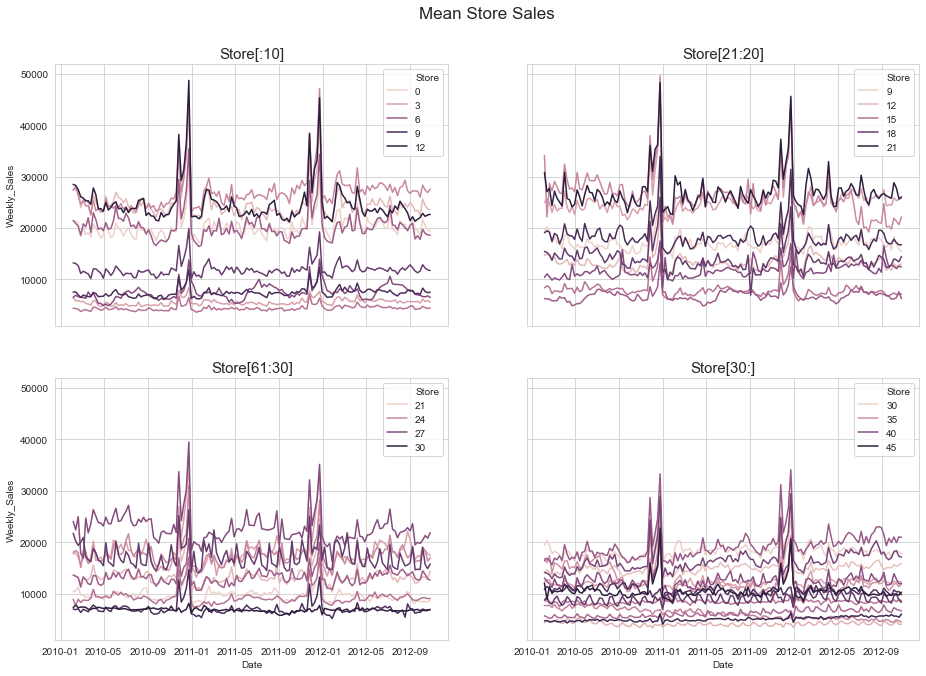

In [70]:
## Date * Department - MEans sales lineplot
Store_mean = trte_basic_feat.groupby(['Store','Date'],as_index=False).mean()
fig, axes = plt.subplots(2, 2, figsize=(15, 10),sharey=True,sharex=True)
fig.suptitle('Mean Store Sales',fontsize=17)
fig.subplots_adjust(wspace=0.2,hspace=0.2)
fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)

## we will divide our plots into 4 equal parts and plot linegraph
sns.lineplot(ax=axes[0,0],data=Store_mean.query('Store <= 10'),x='Date',y='Weekly_Sales',hue='Store')
sns.lineplot(ax=axes[0,1],data=Store_mean.query('Store > 10 and Store <=20 '),x='Date',y='Weekly_Sales',hue='Store')
sns.lineplot(ax=axes[1,0],data=Store_mean.query('Store > 20 and Store <=30'),x='Date',y='Weekly_Sales',hue='Store')
sns.lineplot(ax=axes[1,1],data=Store_mean.query('Store > 30'),x='Date',y='Weekly_Sales',hue='Store')

axes[0,0].set_title('Store[:10]',fontsize=15)
axes[0,1].set_title('Store[21:20]',fontsize=15)
axes[1,0].set_title('Store[61:30]',fontsize=15)
axes[1,1].set_title('Store[30:]',fontsize=15)
plt.show()

* Similar to deparment we can see few stores also has higher mean sales 

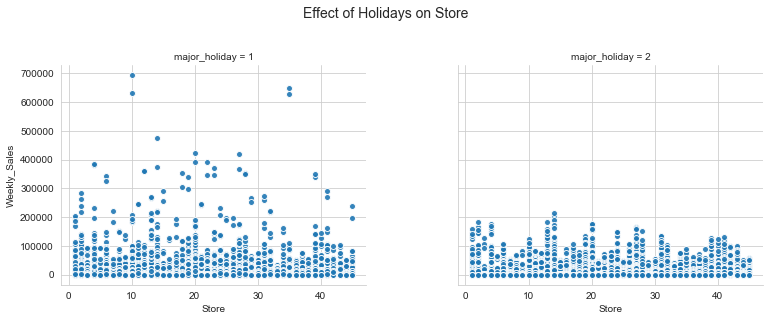

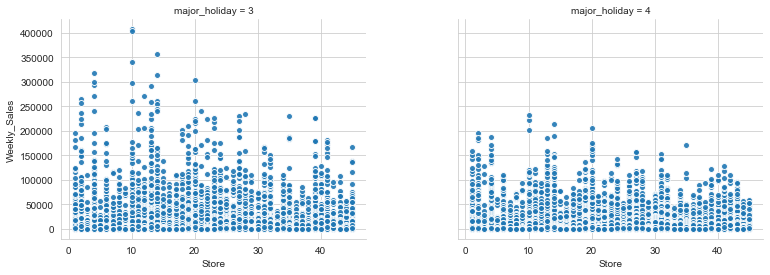

In [71]:
## effect of holidays on Stores
g = sns.FacetGrid(trte_basic_feat, col="major_holiday",  
                  col_order=[1,2],
                  aspect=1.2, size=4.5, palette=['Yellow','Blue',"Green",'Pink'])
g.map(plt.scatter, "Store", "Weekly_Sales", alpha=0.9, 
      edgecolor='white')
fig = g.fig
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Effect of Holidays on Store', fontsize=14)

g = sns.FacetGrid(trte_basic_feat, col="major_holiday",  
                  col_order=[3,4],
                  aspect=1.2, size=4.5, palette=['Yellow','Blue',"Green",'Pink'])
g.map(plt.scatter, "Store", "Weekly_Sales", alpha=0.9, 
      edgecolor='white')
fig = g.fig
fig.subplots_adjust(top=0.8, wspace=0.3)

                                                        

<b>Observations</b> :
* Similar to Department we can see that stores also have similar effect on sales during Holidays
* We can say that Christmas and Thanksgiving are the major holidays which uplifts the sales scale.

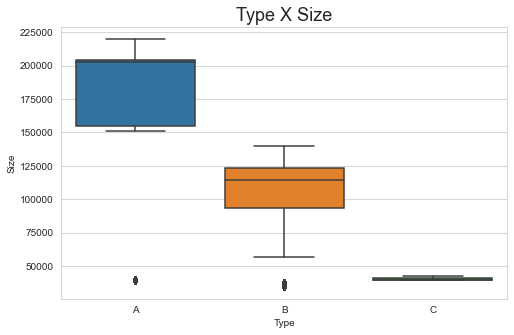

In [72]:
## Size*Type -scatter bubble
fig = plt.figure(figsize=(8,5))
sns.boxplot(data=trte_basic_feat,x='Type',y='Size')
plt.title('Type X Size',fontsize=18)
plt.show()

<b>Observations</b> : 
* Here we can see how A,B and C stores are clearly differentiated by their size
* We already exlored how Type A > B > C.Size here confirms bigger the store bigger the size.

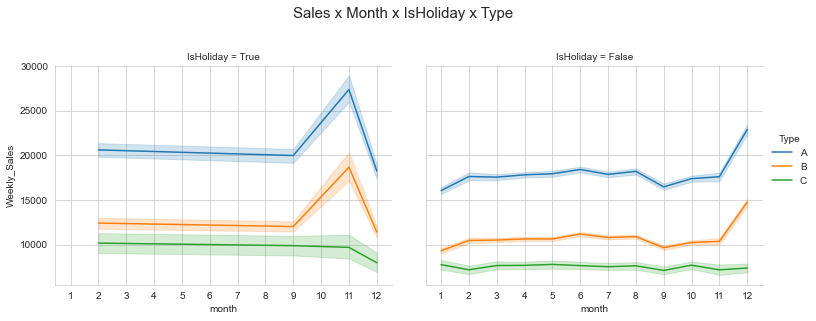

In [73]:
## Month*Holiday*Type - Box plot
g = sns.FacetGrid(trte_basic_feat,col='IsHoliday',col_order=[True,False],hue='Type',hue_order=['A','B','C'],
                 aspect=1.2,size=4.5)
g.map(sns.lineplot,'month','Weekly_Sales')
g.set(xticks=np.arange(1,13))
fig = g.fig
fig.suptitle('Sales x Month x IsHoliday x Type',size=15)
fig.subplots_adjust(top=0.8,wspace=0.1)
l = g.add_legend(title='Type')

<b>Observations:</b>
* Month&Holiday is also a good predictor of sales as we can see during months   9-12 during dolidays there is sales peak in stores A and B .


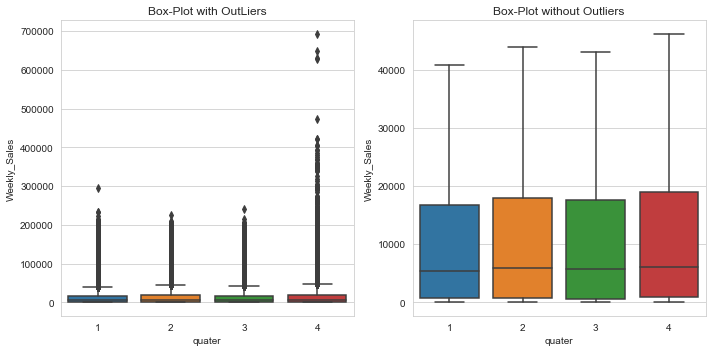

In [74]:
### Let's check how quaters affect the sales
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(data=trte_basic_feat,x='quater',y='Weekly_Sales',)
plt.title("Box-Plot with OutLiers")
plt.subplot(1,2,2)
sns.boxplot(data=trte_basic_feat,x='quater',y='Weekly_Sales',showfliers=False)
plt.title('Box-Plot without Outliers')
plt.tight_layout()

<b>Observations:</b>
* We see that mean sales are almost same across all the quaters.
* Quater 4 has has flier points depecting sudden peak in sales in some week.

### 5.1 Correlation

In [75]:
numerical_featues = ['Weekly_Sales','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment','Size','day', 'day_ofyear','week','month','quater','year']
categorical_features = ['Store', 'Dept','IsHoliday','Type', 'major_holiday']

##### Correlation between numerical features

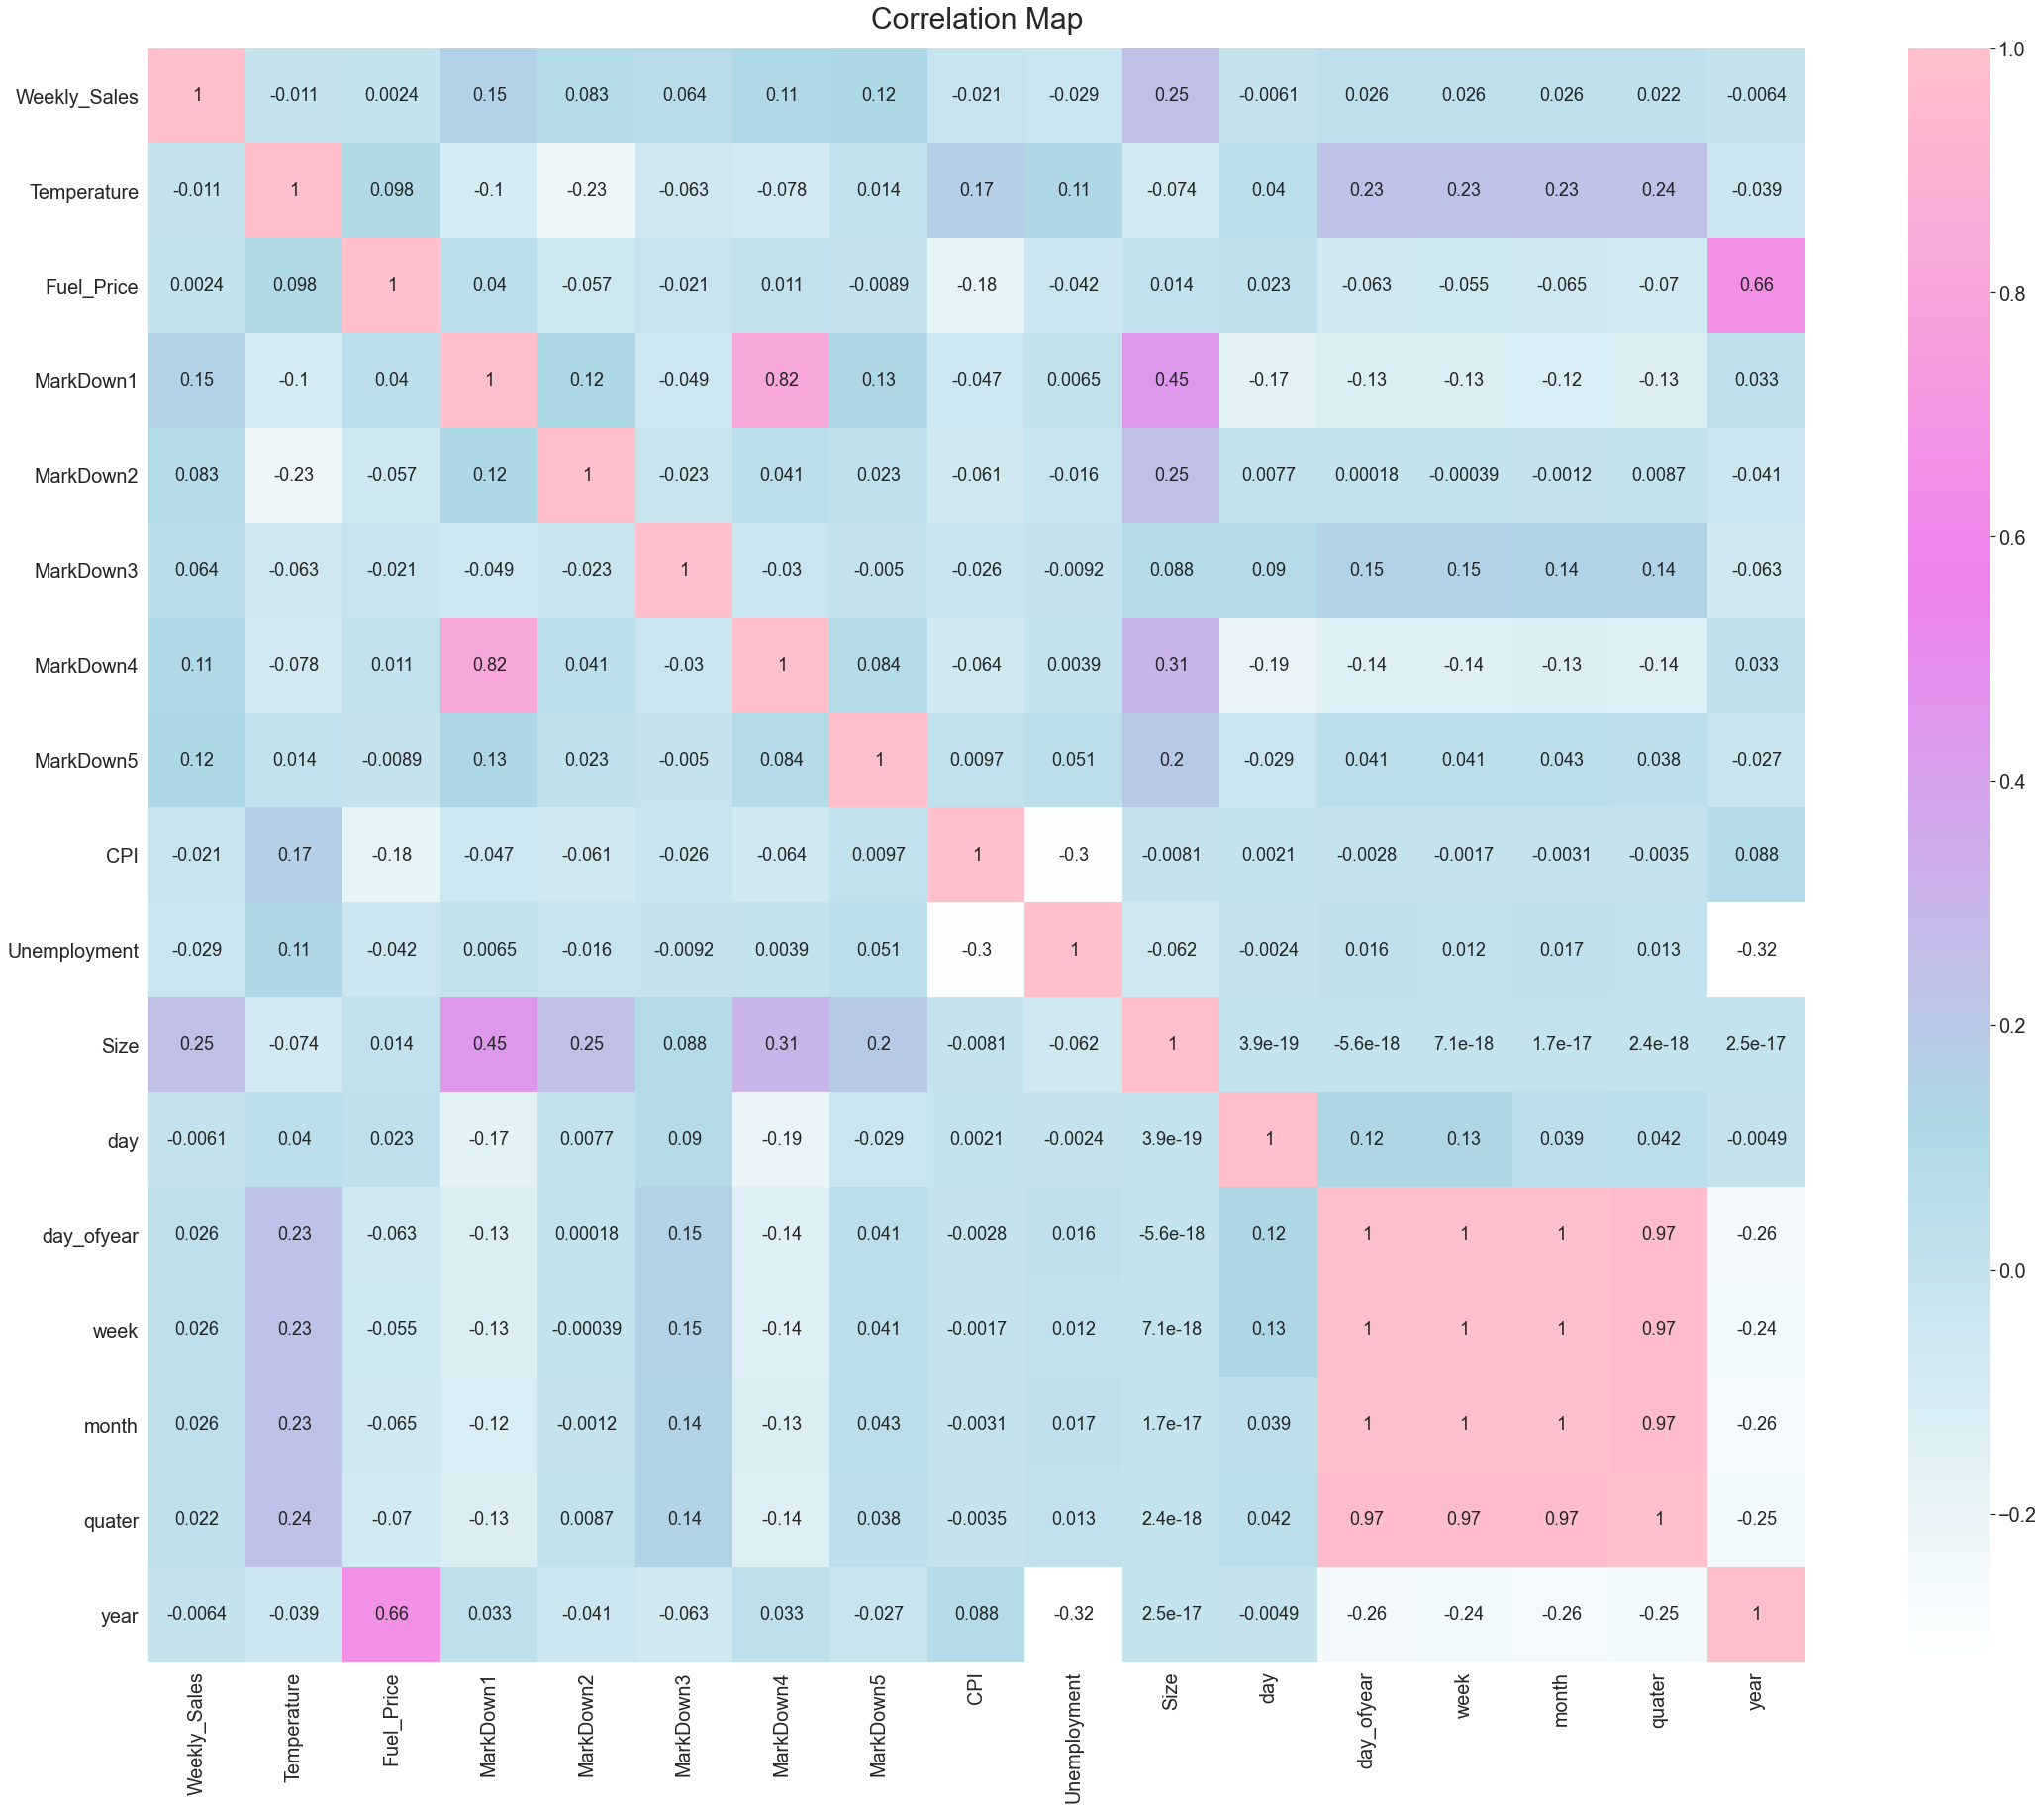

In [76]:
fig = plt.figure(figsize=(25,20))
sns.set(font_scale=1.8)
cmap = sns.blend_palette(colors=['White','lightblue','violet','pink'],n_colors=4,as_cmap=True)
ssn = sns.heatmap(trte_basic_feat[numerical_featues].corr(),annot=True,annot_kws={'fontsize':18},cmap=cmap)
plt.title("Correlation Map",fontdict={'size':30},pad=20)
fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.5)  # scale current size by 1.5
plt.show()

<b>Observations</b>: 
* Fuel price and year are highly correlated,hence we can decide to drop Fuel_price.
* MarkDown1 and MarkDown4 are corelated ,lets drop markdown 4
* Size has the strongest corelation(0.2) with Weekly_Sales.
* Fuel_price and Temperature has very weak coorelation with sales
* Week is strongly co-related with month,dayofyear and quater we will drop them
* let's drop column dayofyear and month as it's strongly corelated to week.

In [77]:
## DRopping Fuel_price and markdown4
trte_basic_feat.drop(columns=['Fuel_Price','MarkDown4','day_ofyear','quater'],inplace=True)
print('Columns : Fuel_Price,MarkDown4,day_ofyear,quater has been dropped')

Columns : Fuel_Price,MarkDown4,day_ofyear,quater has been dropped


##### Correlation between numerical features and categorical features

Anova -Test : is a statistical test which can be used to determine the correlation between categorical and continuous 
variable.Anova test performs analysis of variance by calculating population means of each category.Annova test performed when there are atleast three categories.Here the null hypothesis(H0) states that the variables are not correlated. we can say if p_value < alpha(0.05) value we reject our null hypotheseis.If p_value > alpha value and F value  > f critical we accept our null hypothesis 

In [78]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']  ## calculating mean_sq
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq']) ### will tell the variance explained sseffect /sstotal
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq']
    aov = aov[cols]
    return aov
def ols_(column):
    model = ols('Sales ~ C({})'.format(column), data=data).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    return aov_table

for i in categorical_features:
    x = trte_basic_feat.loc[(trte_basic_feat.set_type=='Train')][i]
    y = trte_basic_feat.loc[(trte_basic_feat.set_type=='Train')]['Weekly_Sales']
    data = pd.DataFrame({i:x,'Sales':y})
    aov_table = ols_(i)
    aov = anova_table(aov_table)
    print('Stats Summary for feature ',i,'*'*20)
    print(aov)
    print('Variance explained (eta-squared) by the feature ',i,' :',aov_table['eta_sq'][-2])
    print('\n\n')

Stats Summary for feature  Store ********************
                sum_sq        df       mean_sq            F  PR(>F)    eta_sq
C(Store)  2.100315e+13      44.0  4.773443e+11  1087.347135     0.0  0.091481
Residual  2.085878e+14  475144.0  4.389990e+08          NaN     NaN       NaN
Variance explained (eta-squared) by the feature  Store  : 0.09148076121863773



Stats Summary for feature  Dept ********************
                sum_sq        df       mean_sq            F  PR(>F)    eta_sq
C(Dept)   1.255263e+14      80.0  1.569078e+12  7163.639917     0.0  0.546739
Residual  1.040646e+14  475108.0  2.190337e+08          NaN     NaN       NaN
Variance explained (eta-squared) by the feature  Dept  : 0.546738823094827



Stats Summary for feature  IsHoliday ********************
                    sum_sq        df       mean_sq           F         PR(>F)  \
C(IsHoliday)  2.583926e+11       1.0  2.583926e+11  535.400812  2.196219e-118   
Residual      2.293325e+14  475187.0  4.826153

#####  P.S  degree of correlation using (eta-squared ) 
-  0.001-0.009 -  weak correlation
-  0.01 - 0.2 -  moderate correlation
-  0.2 - 0.5 - good correlation

Observations :
* Using the anova test we checked for correlation between categorical(store,dept,isholiday etc) and numerical variable (sales).
* We see that the department feature is well correlated to weekly sales with 0.54 correlation.
* Store feature is moderately corelated (0.09) with weekly Sales
* We see that type,major holiday and isholiday posesses weak correlation

##  6. Time series Analysis 

<center><b>Why do we perform Time-Series Analysis ?</b> </center>
<p>Using time-series we can get the insight of how time can add weightage in determining the value of an asset/commodity or variable of our concern. In our ususal Machine Learning analysis we check how  the independent variables affecting our dependent variable,order doesn't matter. In our time series analysis we check how the past observations of our target variables varies with respect to time .Here the data is ordered with respect to time which creates a dependency between past and future observations. </p>
<center><b>Time-Series Components !!!</b></center>
<p> There are 4 major components of Time-series <br>
<i>Level:  Average value of the series</i><br>
<i>Trend:   Can be interpreted as a slope.Rate of change within two adjacent values.This is a optional component</i><br>
<i>Seasonality:   Shows if there is any cyclic behaviour in the data.(i.e)Repeatedness after a time period of time</i><br>
<i>Noise:  Uncertain variation which cannot be interpreted  the model<br></p>

In [79]:
## In time -series analysis we are just going to consider the 
## date feature and the weekly sales vale 

## Data loading
## Date has to be parsed to perform date related analysis
## squeeze will convert data frame to series
time_series = pd.read_csv('Clean_train.csv',
                          header=None,
                          usecols=[2,3],skiprows=1,
                          names=['Date',"Weekly_Sales"],
                          parse_dates=["Date"],
                          index_col=0)

In [80]:
time_series_grouped =  time_series.groupby('Date').mean()

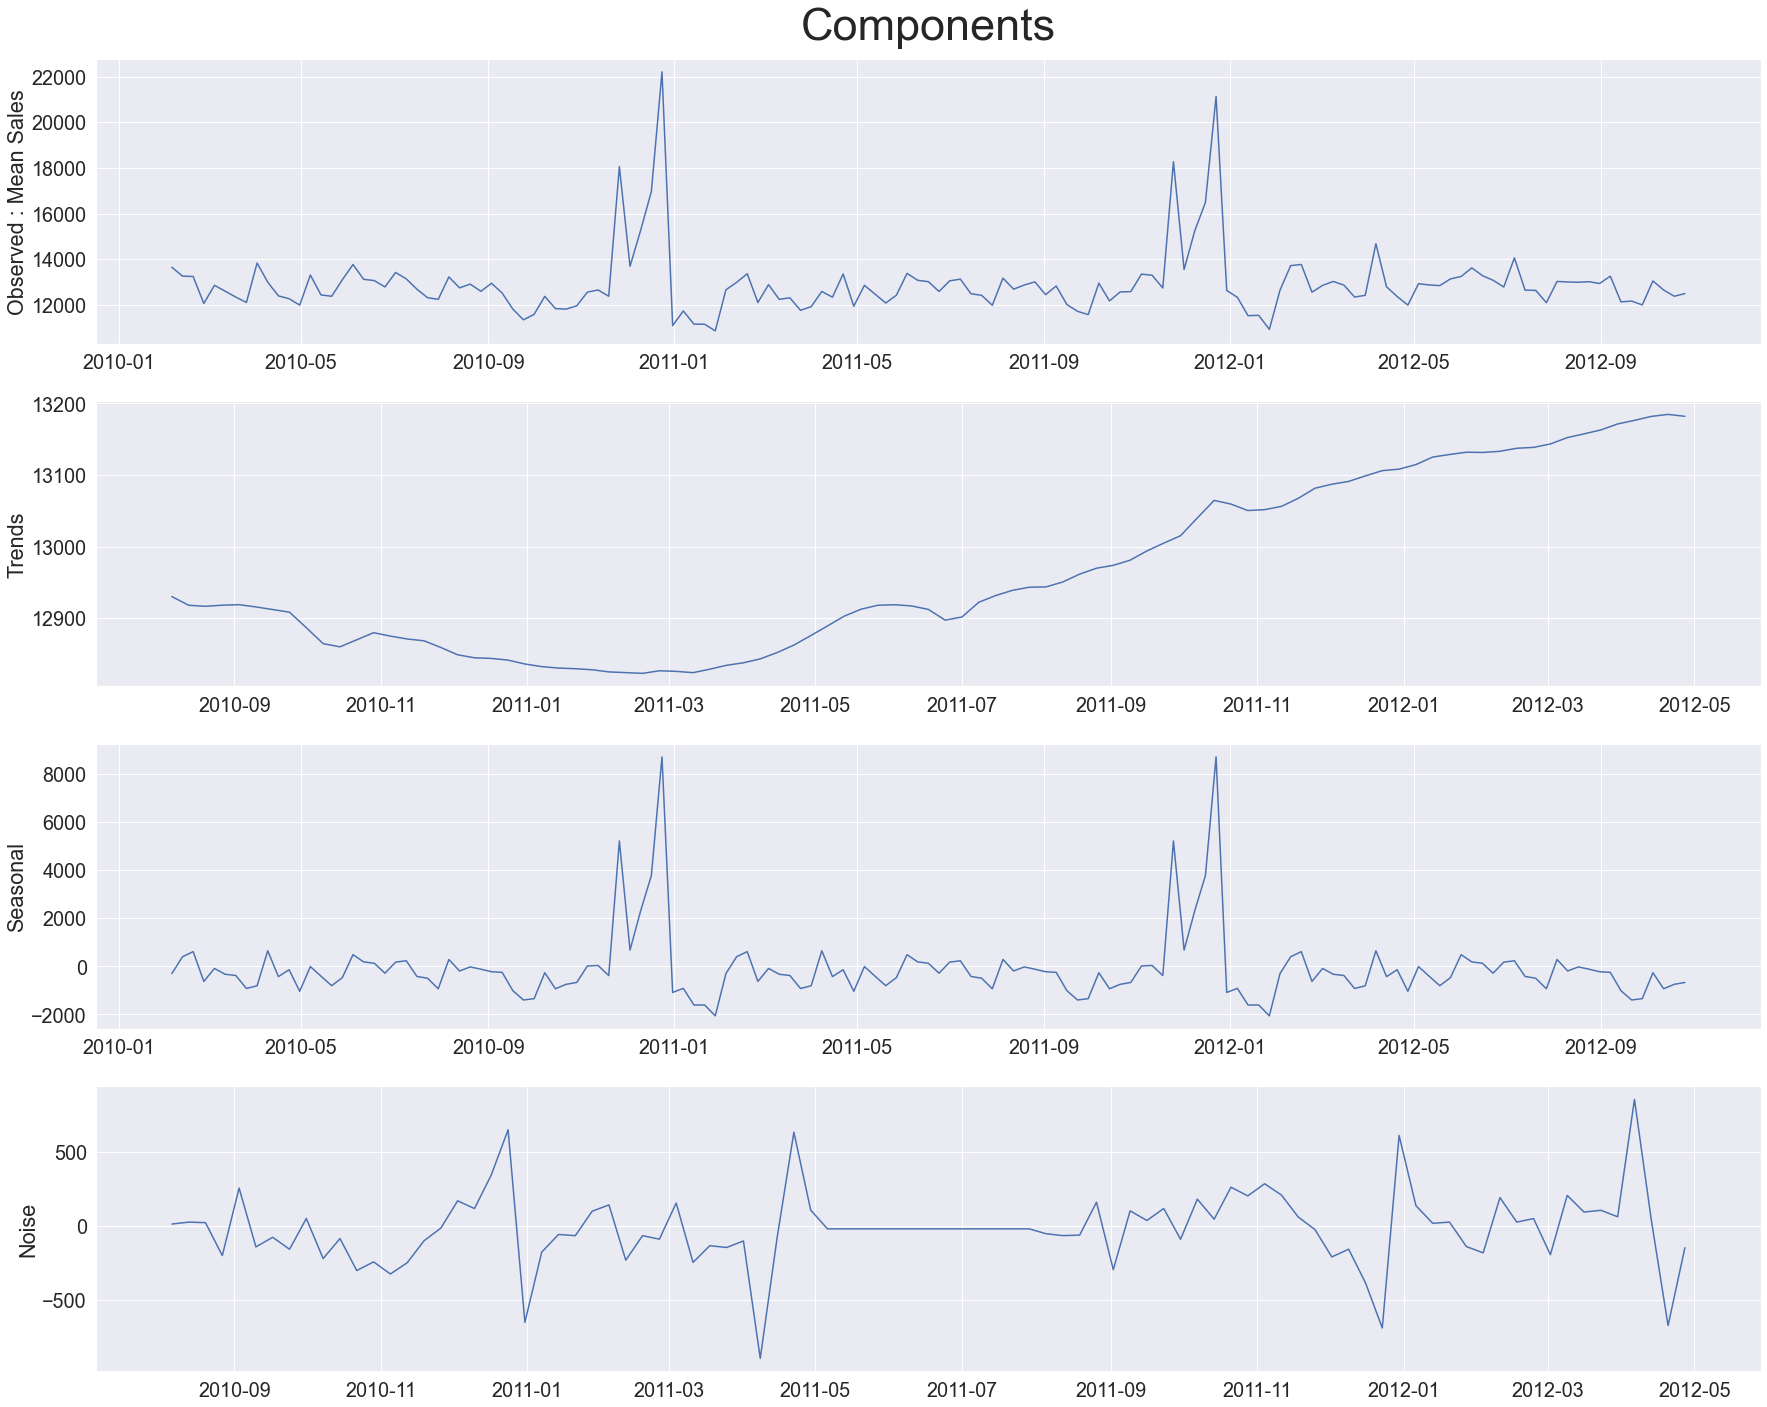

In [81]:
### Check for trend and seasonality noise in data
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(time_series_grouped)

trend = decompose.trend
seasonal = decompose.seasonal
noise = decompose.resid

fig = plt.figure(figsize=(25,20))
#plt.subplots_adjust(top=0.2,wspace=0.12)

plt.subplot(411)
plt.plot(time_series_grouped)
plt.title('Components',fontdict={'fontsize':45},pad=20)
plt.ylabel('Observed : Mean Sales')

plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trends')

plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(noise)
plt.ylabel('Noise')
plt.tight_layout()

* We can see clearly that data contains both upwards and downward trend.
* Additive Seasonality : We can see that there is 90% spike  in  sales during year end every year additively.
* Data its is also quite noisy, which depicts uncertainty in sales in some periods .Here is when we use smoothening technique.We are going to average out some past values which will eventually reduce noise in data.


### 6.1. Time-Series Smoothening Techniques

We are going to implement some Averaging techniques for each of our store and department columns as features.<br>
<b> Lag features :</b> We are using shift() function from pandas library.Here we consider lags based on trend,the trend is yearly so lets take 52 lags <br>
<b> Rolling window : </b>We are using rolling() function from pandas library.Here weConsider a constant  window size(3) and take average of past values within that window.<br>
<b> Expanding window :</b>We are using expand() function from pandas library.Here we Consider a expanding window size(2) and take average of past values within that window.<br>
<b> Exponential weighted moving average :</b>We are using ewm() function from pandas library. Here recent values are given more weight and the weights reduce exponentially as we move further past values<br>
<b> Holt's Winters triple exponential smoothening:</b> Consider smoothening by taking into account of level,trend and  seasons <br>
* Ref : https://towardsdatascience.com/moving-averages-in-python-16170e20f6c<br>
 https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/

In [82]:
def creating_smoothening_columns(df,cols,yhat,alphas=[0.3],lags=[52],esize=1,wsize=3):
    '''creates lag columns,rolling mean column,exponential weighted moving average column to the dataset'''
    
    grouped = df.groupby(cols)
    
    ## calculate rolling mean of specified window size
    # we are shifting by 52 because there is a seasonal trend and we will be able to forecast better.
    ## As we will be able to take  mean of nearest points since we have 40 weeks to predict
    df['rolling_mean'] = np.round(grouped[yhat].apply(lambda x: x.shift(52).rolling(window=wsize,min_periods=1).mean()),3)
    
    ## calculate expanding window of specified size
    df['expanding_mean'] =  np.round(grouped[yhat].apply(lambda x: x.shift(52).expanding(esize).mean()),3)
    
     ## calculate ewm with different alpha combinations
    for a in alphas:
         df['EWM_{}'.format(a)] =  np.round(grouped[yhat].apply(lambda x: x.shift(52).ewm(alpha=a,adjust=False).mean()),3)
            
    ## create lag columns with specified lags
    for l in lags :
        df['lag_{}'.format(l)] =  np.round(grouped[yhat].apply(lambda x: x.shift(l)),3)
    
    return df      


##function call to create smoothed features

trte_featured = creating_smoothening_columns(trte_basic_feat.copy(),['Store','Dept'],'Weekly_Sales',[0.1,0.4,0.5,0.7],[52],1,3)



##### HOLT WINTER's  - TRIPLE EXPONENT SMOOTHENING:
As our data contains additive seasonality.Holt winter's triple exponent smoothening is apt to capture forecast.The values are smoothened at 3 levels namely level,trend and seasonality.

\begin{align*}
 \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} + s_{t+h-m(k+1)} \\
 \ell_{t} &= \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
 b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}\\
 s_{t} &= \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m},
\end{align*}

The forecast $\begin{align}(\hat{y}_{t+h|t})\end{align}$ (h is the number of predictions to be made from t ) is calculated with the combination of level $\begin{align}(\ell_{t})\end{align}$ ,trend $\begin{align}(b_{t})\end{align}$, and seasonal component  $\begin{align}(s_{t})\end{align}$.The level,trend and seasonal factors are smoothened with $\begin{align}(\alpha,\beta^*,\gamma)\end{align}$ In level we are taking the exponential weighted of non-seasonal forecast $\begin{align}(\ell_{t-1} + b_{t-1})\end{align}$ and seasonal adjustment(how much difference from past season) $\begin{align}(y_{t} - s_{t-m})\end{align}$.Seasonal frequency m can be quaterly (m=4),yearly(m=12) based on events .Trend can be intuitively understood as the slope.Trend tells the rate of change between ajacent observations t,(t-1).In trend  we are taking exponential weighted average between past trend $\begin{align}(b_{t-1})\end{align}$   and level adjustment$\begin{align}(\ell_{t} - \ell_{t-1})\end{align}$ (how much difference from past level).Similarly in seasonal component we are considering two factors level and trend. Equation $\begin{align}(y_{t}-\ell_{t-1}-b_{t-1})\end{align}$ is the trend and level adjustment from the current observation.
 <br>
References - https://grisha.org/blog/2016/02/17/triple-exponential-smoothing-forecasting-part-iii/

In [83]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

In [84]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [85]:
def triple_exponential_smoothing(series,slen, alpha, beta, gamma, n_preds):
    result = []
    # n_preds is the number of predictions to be made
    abs_err = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            abs_err.append(0)
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            final_val = smooth+trend+seasonals[i%slen]
            abs_err.append(abs(series[i] - final_val))
            result.append(final_val)
    
    return result,abs_err

### Hyperparameter Tuning Alpha,Beta and Gamma values

In [86]:
season_len = 52
mape = []
## lets manually fine tune alpha beta and gamma 
alpha = [0.25,0.2,0.15,0.1]
beta = [0.1,0.15,0.20,0.25]
gamma = [0.1,0.15,0.20,0.08,0.05]
fine_tune = []
length = len(trainset_merged)
start = datetime.now()
if not os.path.isfile('holts.pkl'):
    for a in alpha :
        for b in beta:
            for g in gamma:
                predict_list_2,act_sum,predict_sum=[],[],[]
                for s in ustore:
                    for d in udept:
                        ## for each store and dept pass the target column values
                        data=trainset_merged.loc[(trainset_merged.Store ==s )&(trainset_merged.Dept==d)]['Weekly_Sales'].reset_index(drop=True)
                        
                        # perform smoothening (return predict values,absolute error)
                        predict_values_2,abs_val = triple_exponential_smoothing(data, season_len, a, b, g, 0)
                        
                        ## Add to final predict list
                        predict_list_2.extend(predict_values_2)
                        act_sum.append(sum(data))
                        predict_sum.append(sum(abs_val))
                ## calculate MAPE per combination        
                mape_err = (sum(predict_sum)/length)/(sum(act_sum)/length)
                print('Mape% with alpha : {} ,beta:{}, gamma:{} is '.format(a,b,g),mape_err*100)
                fine_tune.append((a,b,g,mape_err*100))     
    pkl.dump(fine_tune,open('holts.pkl','wb'))            
else:
    fine_tune = pkl.load(open('holts.pkl','rb'))
    print('Parameters already tuned for Triple smoothening !!!! ')

print('Time required to run this cell:',datetime.now()-start)

Parameters already tuned for Triple smoothening !!!! 
Time required to run this cell: 0:00:00.001997


In [87]:
## lets get the parameters which gives minimum mape value
from operator import itemgetter
best_params = fine_tune[np.argmin(list(map(itemgetter(3),fine_tune)))]
print('For triple exponential smoothening the minimum mape value was found to be ',best_params[3])
print('The best alpha,beta and gamma parameters for triple exponential smoothening having minimum MAPE value are',best_params[:3])

For triple exponential smoothening the minimum mape value was found to be  4.187637418634715
The best alpha,beta and gamma parameters for triple exponential smoothening having minimum MAPE value are (0.25, 0.1, 0.2)


In [88]:
### train with  best_alpha ,alpha beta and gama 
holt_winter_avg = []
a,b,g=best_params[:3]
predict_weeks = 39
for s in ustore:
    for d in udept:
        if (s,d) not in store_dept_with_all_zeros_sales:
            data=trte_basic_feat.loc[(trte_basic_feat.Store ==s )&(trte_basic_feat.Dept==d)
                                     &(trte_basic_feat.set_type=='Train')]['Weekly_Sales'].reset_index(drop=True)
            predict_values_2,abs_val = triple_exponential_smoothing(data, season_len, a, b, g, predict_weeks)
            holt_winter_avg.extend(predict_values_2)

In [89]:
trte_featured['holt_avg']  = np.round(holt_winter_avg,3)

In [90]:
### lets look at our featured data
trte_featured.head(2)

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature    MarkDown1  \
0      1     1 2010-02-05      24924.50      False        42.31  8536.592778   
1      1     1 2010-02-12      46039.49       True        38.51  8536.592778   

     MarkDown2    MarkDown3    MarkDown5         CPI  Unemployment Type  \
0  3346.401918  1670.797978  4428.307667  211.096358         8.106    A   
1  3346.401918  1670.797978  4428.307667  211.242170         8.106    A   

     Size set_type  week  year  month  day  major_holiday  rolling_mean  \
0  151315    Train     5  2010      2    5            0.0           NaN   
1  151315    Train     6  2010      2   12            4.0           NaN   

   expanding_mean  EWM_0.1  EWM_0.4  EWM_0.5  EWM_0.7  lag_52   holt_avg  
0             NaN      NaN      NaN      NaN      NaN     NaN  24924.500  
1             NaN      NaN      NaN      NaN      NaN     NaN  44921.068

### Label encoding Categorical features


In [ ]:
trte_featured['IsHoliday'] = trte_featured['IsHoliday'].map({True:1,False:0})
trte_featured['Type'] = trte_featured['Type'].map({'A':1,"B":2,"C":3}) 

trte_basic_feat['IsHoliday'] = trte_basic_feat['IsHoliday'].map({True:1,False:0})
trte_basic_feat['Type'] = trte_featured['Type']


trainset_merged['IsHoliday'] = trainset_merged['IsHoliday'].map({True:1,False:0})
trainset_merged['Type'] = trainset_merged['Type'].map({'A':1,"B":2,"C":3}) 


testset_merged['IsHoliday'] = testset_merged['IsHoliday'].map({True:1,False:0})
testset_merged['Type'] = testset_merged['Type'].map({'A':1,"B":2,"C":3}) 


In [92]:
### let's put the dataframe to csv
trte_featured.to_csv('trte_fetaured.csv',index=False,encoding='utf-8', date_format='%Y-%m-%d')
trainset_merged.to_csv('trainset_merged.csv',index=False,encoding='utf-8', date_format='%Y-%m-%d')
testset_merged.to_csv('testset_merged.csv',index=False,encoding='utf-8', date_format='%Y-%m-%d')
trte_basic_feat.to_csv('trte_basic_feat.csv',index=False,encoding='utf-8', date_format='%Y-%m-%d')

#### Feature Importance using Forward Feature Selection for basic features 

In [75]:
input_ =  trte_basic_feat.loc[trte_basic_feat.set_type=='Train']
input_['Date'] = input_.Date.map(datetime.toordinal)
input_ =  input_.fillna(-1).reset_index(drop=True)
output = input_.Weekly_Sales
input_ = input_.drop(columns = ['Weekly_Sales','set_type'],axis=1)

In [76]:
seqfs =  SFS(RandomForestRegressor(n_estimators=200,random_state=2),k_features='best',forward=True,
             floating=False,verbose=2,scoring='neg_mean_absolute_error',cv=0)

In [103]:
seqfs.fit(input_,output,custom_feature_names=input_.columns)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 13.6min finished

[2021-07-20 13:49:48] Features: 1/18 -- score: -7998.225877432984[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 20.3min finished

[2021-07-20 14:10:09] Features: 2/18 -- score: -2370.980427488272[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 28.0min finished

[2021-07-20 14:38:10] Features: 3/18 -- score: -542.2262471597617[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(cv=0,
                          estimator=RandomForestRegressor(n_estimators=200,
                                                          random_state=2),
                          k_features='best', scoring='neg_mean_absolute_error',
                          verbose=2)

In [140]:
df = pd.DataFrame.from_dict(seqfs.get_metric_dict()).T
sorted_df = df[['feature_names','avg_score']].sort_values(by='avg_score',ascending=False).reset_index(drop=True)

In [149]:
sorted_df

feature_names avg_score
0   (Store, Dept, Date, IsHoliday, Size, week, mon...  -384.817
1   (Store, Dept, Date, IsHoliday, Type, Size, wee...  -384.818
2   (Store, Dept, Date, Size, week, month, day, ma...  -384.846
3   (Store, Dept, Date, IsHoliday, Type, Size, wee...   -384.95
4   (Store, Dept, Date, Size, week, day, major_hol...  -385.134
5   (Store, Dept, Date, IsHoliday, CPI, Type, Size...   -387.06
6                (Store, Dept, Date, Size, week, day)  -387.828
7   (Store, Dept, Date, IsHoliday, CPI, Unemployme...  -390.099
8   (Store, Dept, Date, IsHoliday, Temperature, CP...   -394.64
9   (Store, Dept, Date, IsHoliday, Temperature, Ma...  -409.507
10                     (Store, Dept, Date, week, day)  -419.531
11  (Store, Dept, Date, IsHoliday, Temperature, Ma...  -419.913
12  (Store, Dept, Date, IsHoliday, Temperature, Ma...  -425.013
13  (Store, Dept, Date, IsHoliday, Temperature, Ma...   -429.66
14                          (Store, Dept, Date, week)  -468.498
15                                (Store, Dept, Date)  -542.226
16                                      (Store, Dept)  -2370.98
17                                            (Dept,)  -7998.23

In [155]:
print('Below feature combination gives the lowest mean abolute error on  performing model:\n ',sorted_df.iloc[1]['feature_names'])

Below feature combination gives the lowest mean abolute error on  performing model:
  ('Store', 'Dept', 'Date', 'IsHoliday', 'Type', 'Size', 'week', 'month', 'day', 'major_holiday')


* REfs:
https://plotly.com/python/figure-labels/ <br>

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/#:~:text=Level%3A%20The%20average%20value%20in,random%20variation%20in%20the%20series.<br>

https://towardsdatascience.com/moving-averages-in-python-16170e20f6c
https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/<br>

https://www.r-craft.org/r-news/using-anova-to-get-correlation-between-categorical-and-continuous-variables/


In [24]:
date=dt.datetime.toordinal(dt.datetime())

TypeError: an integer is required (got type str)

In [25]:
import datetime as dt


In [26]:
date

['05', '04', '2012']

In [98]:
date = '05-12-2012'.split('-')
dt.date(int(date[0]), int(date[1]), int(date[2])).strftime("%V")

'49'

In [31]:
datetime.date(int(date[2]), int(date[1]), int(date[0])).year

2012

In [6]:
import pandas as pd
trte_featured =  pd.read_csv('trte_featured.csv')

In [35]:
size_list = np.array(trte_featured.groupby(['Store','Size'],as_index=False).count()['Size'])
type_list = np.array(trte_featured.groupby(['Store','Type'],as_index=False).count()['Type'])

In [ ]:
store_dept_with_all_zeros_sales,store_list,type_list = 

In [36]:
pkl.dump([store_dept_with_all_zeros_sales,size_list,type_list],open('saved_variables.pkl','wb'))

In [2]:
import pickle as pkl
store_dept_with_all_zeros_sales,size_list,type_list =  pkl.load(open('model_deployment/saved_variables.pkl','rb'))

In [3]:
store_dept_with_all_zeros_sales

[(1, 39),
 (1, 43),
 (1, 50),
 (1, 65),
 (2, 43),
 (2, 50),
 (2, 65),
 (3, 37),
 (3, 39),
 (3, 43),
 (3, 48),
 (3, 50),
 (3, 58),
 (3, 65),
 (3, 93),
 (3, 99),
 (4, 43),
 (4, 50),
 (4, 65),
 (5, 37),
 (5, 39),
 (5, 43),
 (5, 48),
 (5, 50),
 (5, 65),
 (5, 83),
 (5, 93),
 (5, 99),
 (6, 39),
 (6, 43),
 (6, 50),
 (6, 65),
 (7, 37),
 (7, 39),
 (7, 43),
 (7, 50),
 (7, 65),
 (8, 39),
 (8, 43),
 (8, 48),
 (8, 50),
 (8, 65),
 (9, 37),
 (9, 39),
 (9, 43),
 (9, 50),
 (9, 58),
 (9, 65),
 (9, 83),
 (9, 99),
 (10, 39),
 (10, 43),
 (10, 65),
 (10, 99),
 (11, 39),
 (11, 43),
 (11, 65),
 (12, 37),
 (12, 39),
 (12, 43),
 (12, 48),
 (12, 50),
 (12, 65),
 (13, 39),
 (13, 65),
 (14, 37),
 (14, 39),
 (14, 48),
 (14, 65),
 (15, 37),
 (15, 39),
 (15, 65),
 (16, 37),
 (16, 39),
 (16, 43),
 (16, 50),
 (16, 65),
 (17, 37),
 (17, 39),
 (17, 43),
 (17, 50),
 (17, 65),
 (18, 37),
 (18, 43),
 (18, 65),
 (19, 43),
 (19, 65),
 (20, 39),
 (20, 43),
 (20, 65),
 (21, 37),
 (21, 39),
 (21, 43),
 (21, 65),
 (22, 37),
 (22,

In [20]:
trte_featured.loc[(trte_featured.Store==2)&(trte_featured.Dept==10)&(trte_featured['set_type']=='Train')][['Store','Dept','Date','IsHoliday','Weekly_Sales']]


Store  Dept        Date  IsHoliday  Weekly_Sales
15652      2    10  2010-02-05          0      39602.47
15653      2    10  2010-02-12          1      37984.44
15654      2    10  2010-02-19          0      38889.43
15655      2    10  2010-02-26          0      41137.74
15656      2    10  2010-03-05          0      39883.50
...      ...   ...         ...        ...           ...
15790      2    10  2012-09-28          0      37104.67
15791      2    10  2012-10-05          0      36361.28
15792      2    10  2012-10-12          0      35332.34
15793      2    10  2012-10-19          0      35721.09
15794      2    10  2012-10-26          0      34260.76

[143 rows x 5 columns]